In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils import data
import numpy as np
import matplotlib.pyplot as plt
import os
import cProfile, pstats, io
from pstats import SortKey
from random import randint


print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

if os.path.exists("checkpoint.pt"):
    os.remove("checkpoint.pt")

torch.manual_seed(2)   # reproducible

OPTIMIZATION_PLUGIN = 'GradDescent' # 'Bayesian' or 'Scikit' or 'GradDescent'
#Bayesian requires: $ conda install -c conda-forge bayesian-optimization

GET_STATS = False
GPU_SELECT = 2 # can be 0, 1, 2 (both)
PARALLEL_PROCESSES = 2
TRIALS = 50
RANDOM_STARTS = 50
LR  = 1e-5                    # learning rate
SCI_LR =  1e-5
LR2 = 1e-5
SCI_MM = 0.5                  # momentum - used only with SGD optimizer
MM = 0.5
L_FIRST = 24                  # initial number of channels
KERNEL_X = 24
patience = 21                 # if validation loss not going down, wait "patience" number of epochs
accuracy = 0
MaxCredit = -800

CreditVector = np.zeros(RANDOM_STARTS + TRIALS)
CreditVector = CreditVector - 800
CreditVec = np.zeros(RANDOM_STARTS + TRIALS)
count = 0

pr = cProfile.Profile()

if GET_STATS:
    pr.enable()
    

if GPU_SELECT == 2:
    if torch.cuda.device_count() > 1:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("Using", torch.cuda.device_count(), "NVIDIA 1080TI GPUs!")

if GPU_SELECT == 1:
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")    
    print("Using one (the second) NVIDIA 1080TI GPU!")

if GPU_SELECT == 0:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")       
    print("Using one (the first) NVIDIA 1080TI GPU!")


PyTorch Version:  1.1.0
Torchvision Version:  0.3.0
Using 2 NVIDIA 1080TI GPUs!


In [2]:
from early_stopping import EarlyStopping
from dataset import dataset


early_stopping = EarlyStopping(patience=patience, verbose=True)  # initialize the early_stopping object

# Counter for the execution time
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

In [3]:
if OPTIMIZATION_PLUGIN == 'Scikit' :
    from skopt import gp_minimize
    from sklearn.datasets import load_boston
    from sklearn.ensemble import GradientBoostingRegressor
    from sklearn.model_selection import cross_val_score
    from skopt.space import Real, Integer
    from skopt.utils import use_named_args
    from skopt.plots import plot_convergence
    from functools import partial
    from skopt.plots import plot_evaluations
    from skopt import gp_minimize, forest_minimize, dummy_minimize, gbrt_minimize
    from skopt.plots import plot_objective
    from sklearn.preprocessing import LabelEncoder
    from sklearn.preprocessing import CategoricalEncoder
    from skopt.space import Real, Categorical, Integer
    from sklearn.externals.joblib import Parallel, delayed

    #SCI_LR = Categorical(categories=[1e-1, 3e-1, 5e-1, 7e-1, 1e-2, 3e-2, 5e-2, 7e-2, 1e-3, 3e-3, 5e-3, 7e-3, 1e-4, 3e-4, 0.1, 0.2, 0.3, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.001, 0.0001, 1e-5],name= 'SCI_LR')
    SCI_LR = Categorical(categories=[1e-1, 3e-1, 5e-1, 7e-1, 1e-2, 3e-2, 5e-2, 7e-2, 0.1, 0.2, 0.3, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.001],name= 'SCI_LR')
    SCI_MM = Categorical(categories=[0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 0.999], name='SCI_MM')
    SCI_REGULARIZATION = Categorical(categories=[0.0001, 0.0003, 0.0007, 0.001, 0.003, 0.007, 0.01, 0.03, 0.07, 0.1, 0.3, 0.7], name='SCI_REGULARIZATION')
    SCI_EPOCHS = Categorical(categories=[2000, 1000], name='SCI_EPOCHS')
    SCI_optimizer = Categorical(categories=['Adam', 'Adadelta', 'SGD', 'Adagrad', 'AMSGrad', 'AdamW'],name='SCI_optimizer') #
    SCI_loss_type = Categorical(categories=['CrossEntropyLoss', 'MultiMarginLoss','NLLLoss'],name='SCI_loss_type') # 
    SCI_BATCH_SIZE = Categorical(categories=[4, 8, 12, 16, 24, 32, 48, 64, 96, 128, 160, 192, 224, 256], name='SCI_BATCH_SIZE')
    SCI_DROPOUT = Categorical(categories=[0, 0.01, 0.03, 0.07, 0.1, 0.13, 0.17, 0.2, 0.23, 0.27, 0.3, 0.33, 0.37, 0.4] , name = 'SCI_DROPOUT')
    SCI_RELU = Categorical(categories=['True', 'False'] , name = 'SCI_RELU')
    SCI_BIAS = Categorical(categories=['True', 'False'] , name = 'SCI_BIAS')
    SCI_L_SECOND = Categorical(categories=[2, 4, 6, 8, 12, 16, 20, 24, 32, 48, 64], name='SCI_L_SECOND')
    SCI_BN_MOMENTUM = Categorical(categories=[0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99] , name = 'SCI_BN_MOMENTUM') 
    SCI_SGD_MOMENTUM = Categorical(categories=[0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99] , name = 'SCI_SGD_MOMENTUM') 

    dimensions = [SCI_BATCH_SIZE, SCI_MM, SCI_REGULARIZATION, SCI_optimizer, SCI_LR, SCI_loss_type, SCI_DROPOUT, SCI_RELU, SCI_BIAS, SCI_L_SECOND, SCI_EPOCHS, SCI_BN_MOMENTUM, SCI_SGD_MOMENTUM]

    @use_named_args(dimensions = dimensions)

    def objective(SCI_BATCH_SIZE, SCI_MM, SCI_REGULARIZATION, SCI_optimizer, SCI_LR, SCI_loss_type, SCI_DROPOUT, SCI_RELU, SCI_BIAS, SCI_L_SECOND, SCI_EPOCHS, SCI_BN_MOMENTUM, SCI_SGD_MOMENTUM):
        global device  

        loss_func = nn.CrossEntropyLoss()

        def create_loss(LOSS):   
            if LOSS == 'CrossEntropyLoss':
                loss_func = nn.CrossEntropyLoss()
            if LOSS == 'NLLLoss':
                loss_func = nn.NLLLoss()
            else:
                loss_func = nn.MultiMarginLoss()
            return loss_func

        MM = float(str(SCI_MM))
        REGULARIZATION = float(str(SCI_REGULARIZATION))
        optimizer = str(SCI_optimizer)
        LR = float(str(SCI_LR))
        train_losses = []         # to track the training loss as the model trains
        output = 0
        loss = 0
        accuracy = 0
        early_stopping.counter = 0
        early_stopping.best_score = None
        early_stopping.early_stop = False
        early_stopping.verbose = False  
        TEST_RESULTS = torch.zeros(1,2)

    
        loss_type = create_loss(SCI_loss_type)
        
        
        
        from cnn_model import CNN6      
        cnn = CNN6(L_FIRST, SCI_L_SECOND, KERNEL_X, SCI_BIAS, SCI_BN_MOMENTUM, SCI_RELU, SCI_DROPOUT, dataset.CLASSES)     
    
        if GPU_SELECT == 2:
            if torch.cuda.device_count() > 1:
                cnn = nn.DataParallel(cnn,device_ids=[0, 1], dim=0) 
            cnn = cnn.cuda()
        if GPU_SELECT == 1:
            cnn.to(device)  
        if GPU_SELECT == 0:
            cnn.to(device)        

        cnn.apply(CNN6.weights_reset)
        cnn.share_memory()
     

        
        from adamw import AdamW
        
        
        if SCI_optimizer == 'Adam':
            optimizer = optim.Adam(cnn.parameters(), lr=LR, betas=(0.9, 0.99), weight_decay=REGULARIZATION)
        if SCI_optimizer == 'AMSGrad':
            optimizer = optim.Adam(cnn.parameters(), lr=LR, betas=(0.9, 0.99), weight_decay=REGULARIZATION, amsgrad=True)
        if SCI_optimizer == 'AdamW':
            optimizer = AdamW(cnn.parameters(), lr=LR, betas=(0.9, 0.99), weight_decay = REGULARIZATION)            
        if SCI_optimizer == 'SGD':
            optimizer = optim.SGD(cnn.parameters(), lr=LR, momentum=SCI_SGD_MOMENTUM, weight_decay=REGULARIZATION)
        if SCI_optimizer == 'Adadelta':
            optimizer = optim.Adadelta(cnn.parameters(), lr=LR, weight_decay=REGULARIZATION)
        if SCI_optimizer == 'Adagrad':
            optimizer = optim.Adagrad(cnn.parameters(), lr=LR, weight_decay=REGULARIZATION)
    
        from Utillities import Utillities
        Utillities.listing(optimizer, SCI_SGD_MOMENTUM, SCI_BN_MOMENTUM, SCI_L_SECOND, SCI_LR, SCI_RELU, SCI_BIAS, SCI_loss_type, REGULARIZATION, SCI_BATCH_SIZE, SCI_DROPOUT, SCI_LINEARITY)
    
        #SCI_BATCH_SIZE = 1
        # Data Loader for easy mini-batch return in training
        SCI_BATCH_SIZE = int(SCI_BATCH_SIZE)
        train_loader = Data.DataLoader(dataset = dataset.train_dataset, batch_size = SCI_BATCH_SIZE, shuffle = False, num_workers = 0, drop_last=True, pin_memory=True)
        validation_loader = Data.DataLoader(dataset = dataset.validation_dataset, batch_size = SCI_BATCH_SIZE, shuffle = False, num_workers = 0, drop_last=True, pin_memory=True)    
        test_loader = Data.DataLoader(dataset = dataset.test_dataset, batch_size = SCI_BATCH_SIZE, shuffle = False, num_workers = 0, pin_memory=True)
    
        for epoch in range(SCI_EPOCHS):
            loss = None        
            cnn.train().cuda()
            for step, (train_data, train_target) in enumerate(train_loader):   
                train_data, train_target = train_data.to(device), train_target.to(device)
                output, temp = cnn(train_data)                # forward pass: compute predicted outputs by passing inputs to the model     
                loss = loss_func(output, train_target)
                train_losses.append(loss.item())              # record training loss 
                loss.backward()                               # backward pass: compute gradient of the loss with respect to model parameters
                optimizer.zero_grad()
                optimizer.step()                              # perform a single optimization step (parameter update)
      
            cnn.eval().cuda()                 # switch to evaluation (no change) mode           
            valid_loss = 0
            accuracy = 0
            with torch.no_grad():
                for step, (validation_data, validation_target) in enumerate(validation_loader):
                    validation_data, validation_target = validation_data.to(device), validation_target.to(device)
                    output, temp = cnn(validation_data)            # forward pass: compute predicted outputs by passing inputs to the model
                    valid_loss += loss_func(output, validation_target).item()
                    ps = torch.exp(output)
                    equality = (validation_target[0].data == ps.max(dim=1)[1])
                    accuracy += equality.type(torch.FloatTensor).mean()      
               
            train_losses = []
            early_stopping(valid_loss, cnn)
       
            if early_stopping.early_stop:
                if os.path.exists('checkpoint.pt'):
                    print("Loaded the model with the lowest Validation Loss!")
                    #nn.load_state_dict(torch.load('checkpoint.pt', map_location="cuda:1"))  # Choose whatever GPU device number you want
                    cnn.load_state_dict(torch.load('checkpoint.pt', map_location="cuda:1"))  # Choose whatever GPU device number you want
                    cnn.to(device)
                break
      
        cnn.eval()
        class_correct = list(0. for i in range(1000))
        class_total = list(0. for i in range(1000))
        with torch.no_grad():
            for (test_data, test_target) in test_loader:
                test_data, test_target = test_data.to(device), test_target.to(device)
                outputs, temp = cnn(test_data)
                _, predicted = torch.max(outputs, 1)
                c = (predicted == test_target).squeeze()
                for i in range(test_target.size(0)):
                    label = test_target[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1

        for i in range(dataset.CLASSES):
            TEST_RESULTS[0,i] = class_correct[i] / dataset.TESTED_ELEMENTS[i]
            print('Class: ',i,' accuracy: ', TEST_RESULTS[0,i])
            print('Class: ',i,' correct: ', class_correct[i])
        percent = (TEST_RESULTS[0,0]+TEST_RESULTS[0,1])/2
        print('Final percentage: ',percent)
    
        CreditCost = int((1 - TEST_RESULTS[0,0]) * dataset.TESTED_ELEMENTS[0] + (1 - TEST_RESULTS[0,1]) * dataset.TESTED_ELEMENTS[1] * 5)
    
        if TEST_RESULTS[0,0] == 0 or TEST_RESULTS[0,1] == 0 :
            CreditCost = CreditCost + 300
    
        print('Last epoch: ', epoch)
        print('Credit Cost: ',CreditCost)
    
        if os.path.exists('checkpoint.pt'):  
            os.remove('checkpoint.pt') 

        print()
        torch.cuda.empty_cache()
        print()
        
        return CreditCost
    
    #   not working    #res_gp = gp_minimize(objective, dimensions=dimensions, n_calls=TRIALS, random_state=1, verbose=True, acq_func='gp_hedge', acq_optimizer='auto', n_jobs=1)
    #res_gp = forest_minimize(objective, dimensions=dimensions, base_estimator='RF', n_calls=TRIALS, n_random_starts=RANDOM_STARTS, acq_func='EI', x0=None, y0=None, random_state=None, verbose=True, callback=None, n_points=10000, xi=0.01, kappa=1.96, n_jobs=128)
    res_gp = gbrt_minimize(objective, dimensions=dimensions, base_estimator='ET', n_calls=TRIALS+RANDOM_STARTS, n_random_starts=RANDOM_STARTS, acq_func='LCB', x0=None, y0=None, random_state=None, verbose=True, callback=None, n_points=100, xi=0.01, kappa=1.96, n_jobs=1)
    #res_gp = dummy_minimize(objective, dimensions=dimensions, n_calls=TRIALS, x0=None, y0=None, random_state=None, verbose=True, callback=None)      

    "Best score=%.4f" % res_gp.fun
    print("""Best parameters: - optimization=%d""" % (res_gp.x[0]))
  
    print(res_gp)
    plot_convergence(res_gp)
    #plot_evaluations(res_gp)
    #plot_objective(res_gp)
    

|   iter    |  target   | SCI_BA... | SCI_BIAS  | SCI_BN... | SCI_DR... | SCI_EP... | SCI_LI... |  SCI_LR   | SCI_L_... |  SCI_MM   | SCI_RE... | SCI_RELU  | SCI_SG... | SCI_lo... | SCI_op... |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Optimization:  Adagrad (
Parameter Group 0
    initial_accumulator_value: 0
    lr: 0.08264
    lr_decay: 0
    weight_decay: 0.377
)
Batch Normalization Momentum:  0.0
Nodes:  12
LR:  0.08264
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.377
BATCH_SIZE:  55
Dropout:  0.09
Final Linear Layers:  1
average loss: 0.693368
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.3106)
Class:  0  correct:  155.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5800)
Class:  1  correct:  58.0  of  tensor(100.)
Final percentage:  tensor(0.4453)
Last epoch:  22
Credit Cost:  -5

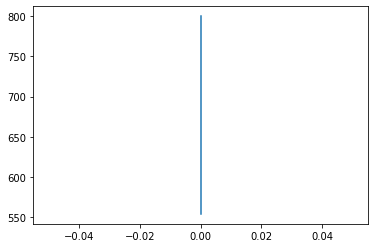

|  1        | -554.0    |  55.71    |  2.433    |  0.000113 |  0.0907   |  1.147e+0 |  1.276    |  0.08264  |  12.37    |  0.397    |  0.3772   |  1.834    |  0.6784   |  1.611    |  6.26     |
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.32229
    weight_decay: 0.485
)
Batch Normalization Momentum:  0.41
Nodes:  31
LR:  0.32229
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.485
BATCH_SIZE:  7
Dropout:  0.17
Final Linear Layers:  1
average loss: 0.692807
Class:  0  accuracy:  tensor(0.7014)
Class:  0  correct:  350.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4600)
Class:  1  correct:  46.0  of  tensor(100.)
Final percentage:  tensor(0.5807)
Last epoch:  21
Credit Cost:  -419


Best Score So Far:  -419


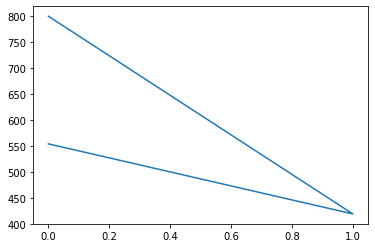

|  2        | -419.0    |  7.396    |  2.334    |  0.4131   |  0.1676   |  1.14e+03 |  1.592    |  0.3223   |  31.05    |  0.3138   |  0.4847   |  2.744    |  0.8857   |  1.254    |  1.234    |
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.27983
    rho: 0.9
    weight_decay: 0.584
)
Batch Normalization Momentum:  0.1
Nodes:  11
LR:  0.27983
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.584
BATCH_SIZE:  25
Dropout:  0.13
Final Linear Layers:  2
average loss: 0.720843
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4409)
Class:  0  correct:  220.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3900)
Class:  1  correct:  39.0  of  tensor(100.)
Final percentage:  tensor(0.4154)
Last epoch:  48
Credit Cost:  -584


Best Score So Far:  -419


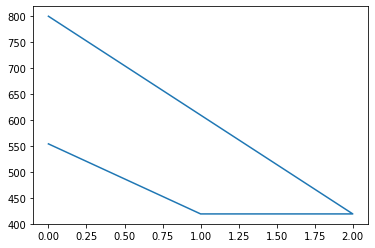

|  3        | -584.0    |  25.06    |  2.748    |  0.09736  |  0.1263   |  1.958e+0 |  2.594    |  0.2798   |  11.47    |  0.6861   |  0.5843   |  1.036    |  0.7426   |  3.957    |  5.482    |
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.12223
    weight_decay: 0.475
)
Batch Normalization Momentum:  0.1
Nodes:  5
LR:  0.12223
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.475
BATCH_SIZE:  38
Dropout:  0.13
Final Linear Layers:  1
average loss: 0.691438
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  21
Credit Cost:  -800


Best Score So Far:  -419


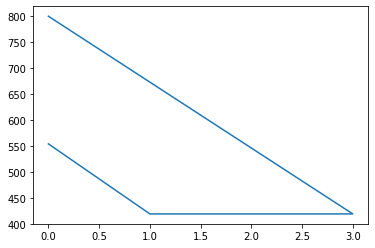

|  4        | -800.0    |  38.78    |  2.571    |  0.1022   |  0.1344   |  1.909e+0 |  1.878    |  0.1222   |  5.901    |  0.02033  |  0.4752   |  1.421    |  0.2629   |  2.47     |  1.32     |
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.28082
    momentum: 0.51
    nesterov: False
    weight_decay: 0.375
)
Batch Normalization Momentum:  0.58
Nodes:  14
LR:  0.28082
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.375
BATCH_SIZE:  75
Dropout:  0.21
Final Linear Layers:  2
average loss: 0.693653
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.6273)
Class:  0  correct:  313.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3300)
Class:  1  correct:  33.0  of  tensor(100.)
Final percentage:  tensor(0.4786)
Last epoch:  23
Credit Cost:  -521


Best Score So Far:  -419


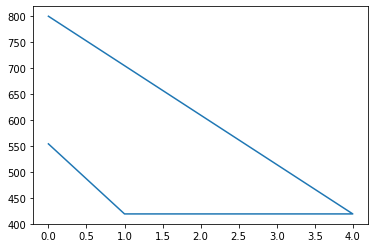

|  5        | -521.0    |  75.19    |  1.292    |  0.5834   |  0.2099   |  1.102e+0 |  2.238    |  0.2808   |  14.43    |  0.05085  |  0.3752   |  2.321    |  0.5097   |  3.824    |  4.513    |
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.37173
    weight_decay: 0.508
)
Batch Normalization Momentum:  0.14
Nodes:  12
LR:  0.37173
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.508
BATCH_SIZE:  116
Dropout:  0.24
Final Linear Layers:  1
average loss: 0.696442
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4269)
Class:  0  correct:  213.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3900)
Class:  1  correct:  39.0  of  tensor(100.)
Final percentage:  tensor(0.4084)
Last epoch:  26
Credit Cost:  -591


Best Score So Far:  -419


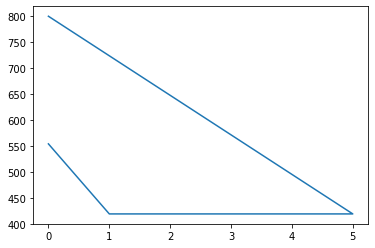

|  6        | -591.0    |  116.0    |  1.274    |  0.1379   |  0.2422   |  1.398e+0 |  1.494    |  0.3717   |  12.43    |  0.7503   |  0.5082   |  2.758    |  0.6174   |  3.245    |  3.09     |
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.05475
    momentum: 0.23
    nesterov: False
    weight_decay: 0.405
)
Batch Normalization Momentum:  0.42
Nodes:  30
LR:  0.05475
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.405
BATCH_SIZE:  37
Dropout:  0.29
Final Linear Layers:  2
average loss: 0.710360
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.3808)
Class:  0  correct:  190.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5100)
Class:  1  correct:  51.0  of  tensor(100.)
Final percentage:  tensor(0.4454)
Last epoch:  39
Credit Cost:  -554


Best Score So Far:  -419


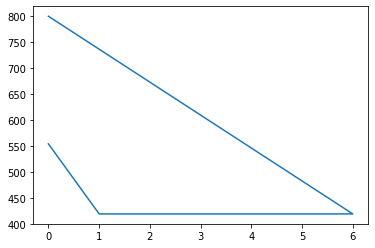

|  7        | -554.0    |  37.47    |  2.783    |  0.4238   |  0.2895   |  1.663e+0 |  2.859    |  0.05475  |  30.48    |  0.45     |  0.4049   |  1.812    |  0.2347   |  3.701    |  4.436    |
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.36433
    weight_decay: 0.651
)
Batch Normalization Momentum:  0.32
Nodes:  20
LR:  0.36433
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.651
BATCH_SIZE:  4
Dropout:  0.16
Final Linear Layers:  2
average loss: 0.693152
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.6774)
Class:  0  correct:  338.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5100)
Class:  1  correct:  51.0  of  tensor(100.)
Final percentage:  tensor(0.5937)
Last epoch:  37
Credit Cost:  -406


Best Score So Far:  -406


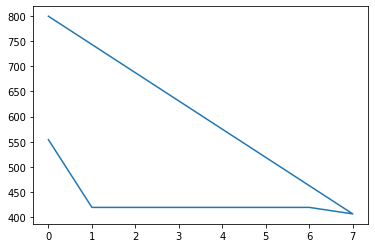

|  8        | -406.0    |  4.356    |  2.228    |  0.3234   |  0.1581   |  1.886e+0 |  2.068    |  0.3643   |  20.7     |  0.01679  |  0.6506   |  2.375    |  0.9873   |  1.515    |  1.821    |
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.28749
    momentum: 0.24
    nesterov: False
    weight_decay: 0.018
)
Batch Normalization Momentum:  0.07
Nodes:  5
LR:  0.28749
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.018
BATCH_SIZE:  119
Dropout:  0.23
Final Linear Layers:  3
average loss: 0.693479
Class:  0  accuracy:  tensor(0.4509)
Class:  0  correct:  225.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5200)
Class:  1  correct:  52.0  of  tensor(100.)
Final percentage:  tensor(0.4855)
Last epoch:  21
Credit Cost:  -514


Best Score So Far:  -406


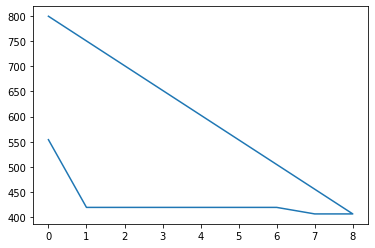

|  9        | -514.0    |  119.6    |  2.387    |  0.06534  |  0.2266   |  1.754e+0 |  3.76     |  0.2875   |  5.728    |  0.02084  |  0.01845  |  1.056    |  0.2437   |  3.571    |  4.228    |
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.2288
    rho: 0.9
    weight_decay: 0.163
)
Batch Normalization Momentum:  0.12
Nodes:  2
LR:  0.2288
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.163
BATCH_SIZE:  72
Dropout:  0.08
Final Linear Layers:  3
average loss: 0.669726
Class:  0  accuracy:  tensor(0.5411)
Class:  0  correct:  270.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6400)
Class:  1  correct:  64.0  of  tensor(100.)
Final percentage:  tensor(0.5905)
Last epoch:  21
Credit Cost:  -409


Best Score So Far:  -406


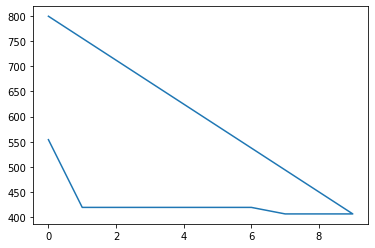

|  10       | -409.0    |  72.55    |  2.676    |  0.1229   |  0.08376  |  1.586e+0 |  3.899    |  0.2288   |  2.559    |  0.8      |  0.1632   |  2.606    |  0.384    |  3.582    |  5.475    |
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.09803
    weight_decay: 0.009
)
Batch Normalization Momentum:  0.06
Nodes:  23
LR:  0.09803
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.009
BATCH_SIZE:  72
Dropout:  0.04
Final Linear Layers:  1
average loss: 0.696442
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.6814)
Class:  0  correct:  340.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4600)
Class:  1  correct:  46.0  of  tensor(100.)
Final percentage:  tensor(0.5707)
Last epoch:  24
Credit Cost:  -429


Best Score So Far:  -406


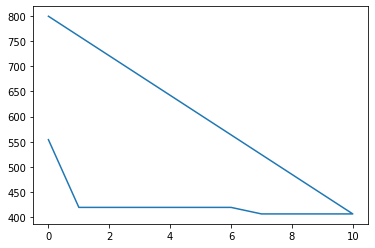

|  11       | -429.0    |  72.97    |  1.272    |  0.05932  |  0.0364   |  1.045e+0 |  1.321    |  0.09803  |  23.39    |  0.5596   |  0.008888 |  1.143    |  0.9576   |  2.699    |  2.218    |
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.10354
    weight_decay: 0.58
)
Batch Normalization Momentum:  0.19
Nodes:  16
LR:  0.10354
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.58
BATCH_SIZE:  35
Dropout:  0.17
Final Linear Layers:  3
average loss: 0.687313
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  21
Credit Cost:  -800


Best Score So Far:  -406


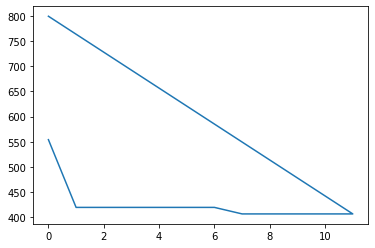

|  12       | -800.0    |  35.29    |  2.48     |  0.1935   |  0.1744   |  1.97e+03 |  3.532    |  0.1035   |  16.81    |  0.6197   |  0.5803   |  1.312    |  0.01839  |  1.209    |  3.913    |
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.22487
    weight_decay: 0.186
)
Batch Normalization Momentum:  0.31
Nodes:  24
LR:  0.22487
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.186
BATCH_SIZE:  79
Dropout:  0.3
Final Linear Layers:  2
average loss: 0.689984
Class:  0  accuracy:  tensor(0.3307)
Class:  0  correct:  165.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4900)
Class:  1  correct:  49.0  of  tensor(100.)
Final percentage:  tensor(0.4103)
Last epoch:  21
Credit Cost:  -589


Best Score So Far:  -406


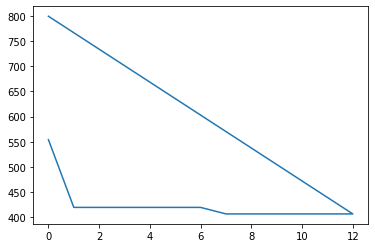

|  13       | -589.0    |  79.18    |  2.132    |  0.3142   |  0.2966   |  1.58e+03 |  2.137    |  0.2249   |  24.36    |  0.6689   |  0.1855   |  1.132    |  0.3664   |  2.883    |  2.259    |
Optimization:  Adagrad (
Parameter Group 0
    initial_accumulator_value: 0
    lr: 0.21462
    lr_decay: 0
    weight_decay: 0.046
)
Batch Normalization Momentum:  0.26
Nodes:  29
LR:  0.21462
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.046
BATCH_SIZE:  97
Dropout:  0.24
Final Linear Layers:  2
average loss: 0.693660
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.3828)
Class:  0  correct:  191.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4100)
Class:  1  correct:  41.0  of  tensor(100.)
Final percentage:  tensor(0.3964)
Last epoch:  22
Credit Cost:  -603


Best Score So Far:  -406


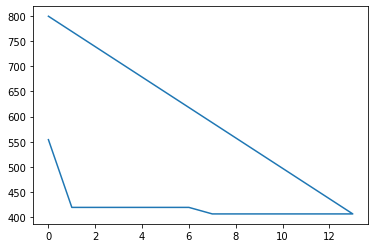

|  14       | -603.0    |  97.34    |  1.132    |  0.2577   |  0.2414   |  1.193e+0 |  2.912    |  0.2146   |  29.74    |  0.2638   |  0.04627  |  2.463    |  0.7645   |  3.714    |  6.583    |
Optimization:  Adagrad (
Parameter Group 0
    initial_accumulator_value: 0
    lr: 0.36709
    lr_decay: 0
    weight_decay: 0.34
)
Batch Normalization Momentum:  0.61
Nodes:  21
LR:  0.36709
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.34
BATCH_SIZE:  5
Dropout:  0.28
Final Linear Layers:  2
average loss: 0.693147
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  21
Credit Cost:  -800


Best Score So Far:  -406


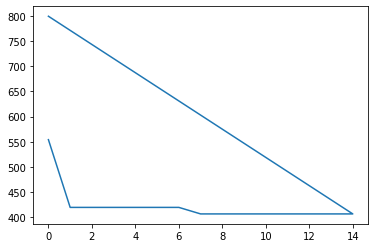

|  15       | -800.0    |  5.73     |  1.466    |  0.6106   |  0.2847   |  1.95e+03 |  2.664    |  0.3671   |  21.25    |  0.3902   |  0.3402   |  2.203    |  0.5441   |  3.769    |  6.503    |
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.01839
    rho: 0.9
    weight_decay: 0.011
)
Batch Normalization Momentum:  0.17
Nodes:  30
LR:  0.01839
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.011
BATCH_SIZE:  52
Dropout:  0.04
Final Linear Layers:  2
average loss: 0.704694
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.3587)
Class:  0  correct:  179.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6000)
Class:  1  correct:  60.0  of  tensor(100.)
Final percentage:  tensor(0.4794)
Last epoch:  22
Credit Cost:  -520


Best Score So Far:  -406


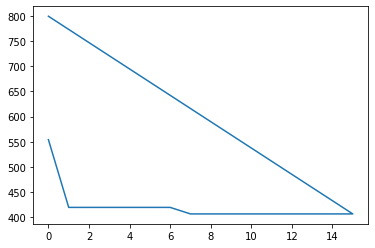

|  16       | -520.0    |  52.96    |  2.917    |  0.1722   |  0.0379   |  1.135e+0 |  2.512    |  0.01839  |  30.44    |  0.8265   |  0.01061  |  1.351    |  0.3287   |  1.392    |  5.849    |
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.18935
    momentum: 0.59
    nesterov: False
    weight_decay: 0.2
)
Batch Normalization Momentum:  0.58
Nodes:  18
LR:  0.18935
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.2
BATCH_SIZE:  46
Dropout:  0.26
Final Linear Layers:  3
average loss: 0.704570
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.3427)
Class:  0  correct:  171.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5100)
Class:  1  correct:  51.0  of  tensor(100.)
Final percentage:  tensor(0.4263)
Last epoch:  26
Credit Cost:  -573


Best Score So Far:  -406


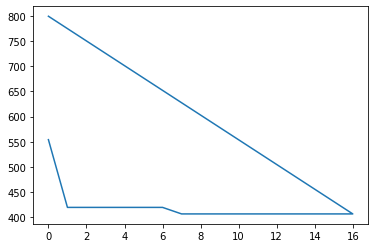

|  17       | -573.0    |  46.75    |  2.871    |  0.5762   |  0.2636   |  1.845e+0 |  3.707    |  0.1894   |  18.39    |  0.798    |  0.2001   |  1.976    |  0.5931   |  1.046    |  4.555    |
Optimization:  Adagrad (
Parameter Group 0
    initial_accumulator_value: 0
    lr: 0.31729
    lr_decay: 0
    weight_decay: 0.294
)
Batch Normalization Momentum:  0.31
Nodes:  20
LR:  0.31729
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.294
BATCH_SIZE:  57
Dropout:  0.27
Final Linear Layers:  1
average loss: 0.693147
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  21
Credit Cost:  -800


Best Score So Far:  -406


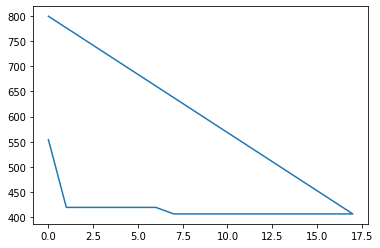

|  18       | -800.0    |  57.78    |  2.607    |  0.3121   |  0.2679   |  1.578e+0 |  1.55     |  0.3173   |  20.36    |  0.0548   |  0.2942   |  2.351    |  0.9094   |  1.001    |  6.851    |
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.12137
    weight_decay: 0.601
)
Batch Normalization Momentum:  0.6
Nodes:  19
LR:  0.12137
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.601
BATCH_SIZE:  50
Dropout:  0.25
Final Linear Layers:  2
average loss: 0.691591
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  21
Credit Cost:  -800


Best Score So Far:  -406


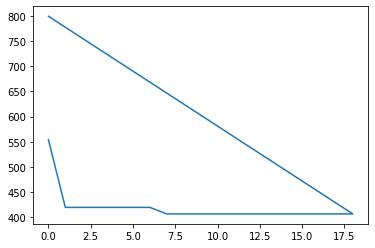

|  19       | -800.0    |  50.7     |  2.938    |  0.5987   |  0.2487   |  1.575e+0 |  2.878    |  0.1214   |  19.61    |  0.7495   |  0.6008   |  2.503    |  0.6911   |  3.585    |  2.933    |
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.25255
    rho: 0.9
    weight_decay: 0.474
)
Batch Normalization Momentum:  0.38
Nodes:  14
LR:  0.25255
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.474
BATCH_SIZE:  87
Dropout:  0.12
Final Linear Layers:  1
average loss: 0.697003
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4609)
Class:  0  correct:  230.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5800)
Class:  1  correct:  58.0  of  tensor(100.)
Final percentage:  tensor(0.5205)
Last epoch:  59
Credit Cost:  -478


Best Score So Far:  -406


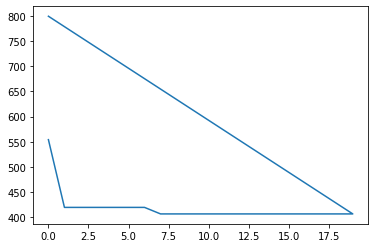

|  20       | -478.0    |  87.18    |  1.897    |  0.3783   |  0.1232   |  1.401e+0 |  1.949    |  0.2525   |  14.91    |  0.9729   |  0.4745   |  1.395    |  0.4224   |  2.027    |  5.778    |
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.21581
    weight_decay: 0.513
)
Batch Normalization Momentum:  0.66
Nodes:  26
LR:  0.21581
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.513
BATCH_SIZE:  113
Dropout:  0.08
Final Linear Layers:  3
average loss: 0.700896
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.6353)
Class:  0  correct:  317.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4600)
Class:  1  correct:  46.0  of  tensor(100.)
Final percentage:  tensor(0.5476)
Last epoch:  26
Credit Cost:  -452


Best Score So Far:  -406


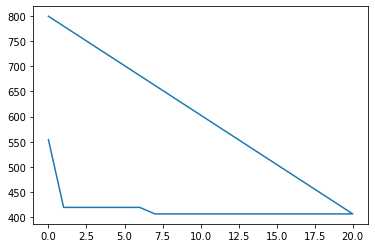

|  21       | -452.0    |  113.1    |  2.799    |  0.6561   |  0.08106  |  1.252e+0 |  3.556    |  0.2158   |  26.06    |  0.5723   |  0.5132   |  2.033    |  0.7632   |  2.701    |  3.79     |
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.32662
    weight_decay: 0.399
)
Batch Normalization Momentum:  0.37
Nodes:  28
LR:  0.32662
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.399
BATCH_SIZE:  46
Dropout:  0.02
Final Linear Layers:  1
average loss: 0.704068
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5691)
Class:  0  correct:  284.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5300)
Class:  1  correct:  53.0  of  tensor(100.)
Final percentage:  tensor(0.5496)
Last epoch:  23
Credit Cost:  -450


Best Score So Far:  -406


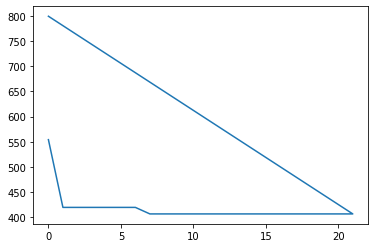

|  22       | -450.0    |  46.49    |  1.136    |  0.3741   |  0.02389  |  1.983e+0 |  1.543    |  0.3266   |  28.25    |  0.688    |  0.3987   |  1.32     |  0.4622   |  2.032    |  2.348    |
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.08526
    momentum: 0.84
    nesterov: False
    weight_decay: 0.146
)
Batch Normalization Momentum:  0.91
Nodes:  16
LR:  0.08526
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.146
BATCH_SIZE:  77
Dropout:  0.27
Final Linear Layers:  1
average loss: 0.744814
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4529)
Class:  0  correct:  226.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5700)
Class:  1  correct:  57.0  of  tensor(100.)
Final percentage:  tensor(0.5115)
Last epoch:  24
Credit Cost:  -488


Best Score So Far:  -406


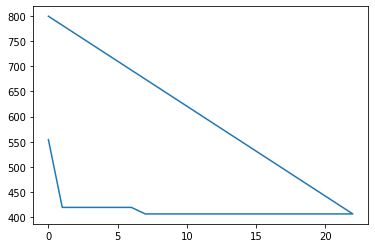

|  23       | -488.0    |  77.47    |  1.621    |  0.9071   |  0.2729   |  1.257e+0 |  1.332    |  0.08526  |  16.99    |  0.7281   |  0.1458   |  1.494    |  0.8432   |  2.243    |  4.694    |
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.22216
    weight_decay: 0.526
)
Batch Normalization Momentum:  0.51
Nodes:  21
LR:  0.22216
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.526
BATCH_SIZE:  32
Dropout:  0.14
Final Linear Layers:  2
average loss: 0.692163
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  21
Credit Cost:  -800


Best Score So Far:  -406


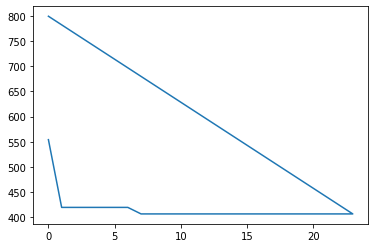

|  24       | -800.0    |  32.97    |  1.203    |  0.5107   |  0.1431   |  1.153e+0 |  2.859    |  0.2222   |  21.62    |  0.1453   |  0.5261   |  1.442    |  0.5142   |  3.348    |  1.134    |
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.3323
    weight_decay: 0.456
)
Batch Normalization Momentum:  0.84
Nodes:  27
LR:  0.3323
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.456
BATCH_SIZE:  44
Dropout:  0.16
Final Linear Layers:  3
average loss: 0.686565
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4910)
Class:  0  correct:  245.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.7100)
Class:  1  correct:  71.0  of  tensor(100.)
Final percentage:  tensor(0.6005)
Last epoch:  26
Credit Cost:  -399


Best Score So Far:  -399


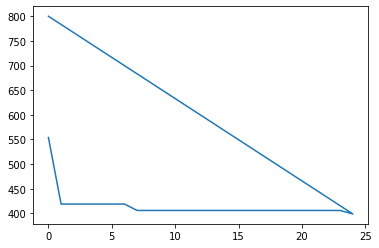

|  25       | -399.0    |  44.22    |  2.737    |  0.8363   |  0.1615   |  1.867e+0 |  3.84     |  0.3323   |  27.62    |  0.09955  |  0.4559   |  2.4      |  0.6041   |  3.391    |  1.207    |
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.32067
    momentum: 0.14
    nesterov: False
    weight_decay: 0.693
)
Batch Normalization Momentum:  0.26
Nodes:  15
LR:  0.32067
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.693
BATCH_SIZE:  99
Dropout:  0.08
Final Linear Layers:  2
average loss: 0.695631
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5872)
Class:  0  correct:  293.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5200)
Class:  1  correct:  52.0  of  tensor(100.)
Final percentage:  tensor(0.5536)
Last epoch:  23
Credit Cost:  -446


Best Score So Far:  -399


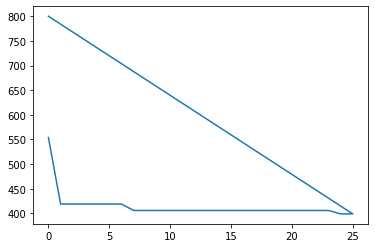

|  26       | -446.0    |  99.51    |  2.456    |  0.2571   |  0.07712  |  1.632e+0 |  2.032    |  0.3207   |  15.38    |  0.7822   |  0.6933   |  1.597    |  0.1416   |  3.695    |  4.244    |
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.14873
    rho: 0.9
    weight_decay: 0.522
)
Batch Normalization Momentum:  0.98
Nodes:  2
LR:  0.14873
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.522
BATCH_SIZE:  124
Dropout:  0.16
Final Linear Layers:  1
average loss: 0.711712
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.6453)
Class:  0  correct:  322.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5200)
Class:  1  correct:  52.0  of  tensor(100.)
Final percentage:  tensor(0.5826)
Last epoch:  77
Credit Cost:  -417


Best Score So Far:  -399


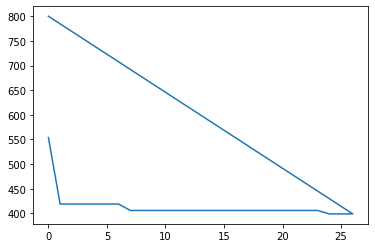

|  27       | -417.0    |  124.9    |  2.267    |  0.984    |  0.1638   |  1.526e+0 |  1.405    |  0.1487   |  2.787    |  0.1611   |  0.522    |  1.06     |  0.3629   |  3.578    |  5.149    |
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.10662
    rho: 0.9
    weight_decay: 0.32
)
Batch Normalization Momentum:  0.44
Nodes:  9
LR:  0.10662
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.32
BATCH_SIZE:  89
Dropout:  0.17
Final Linear Layers:  1
average loss: 0.726772
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.3707)
Class:  0  correct:  185.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4700)
Class:  1  correct:  47.0  of  tensor(100.)
Final percentage:  tensor(0.4204)
Last epoch:  22
Credit Cost:  -579


Best Score So Far:  -399


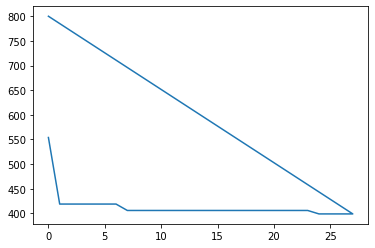

|  28       | -579.0    |  89.68    |  1.375    |  0.4375   |  0.1745   |  1.99e+03 |  1.61     |  0.1066   |  9.865    |  0.7497   |  0.3199   |  1.113    |  0.5034   |  1.634    |  5.784    |
Optimization:  Adagrad (
Parameter Group 0
    initial_accumulator_value: 0
    lr: 0.20935
    lr_decay: 0
    weight_decay: 0.563
)
Batch Normalization Momentum:  0.59
Nodes:  18
LR:  0.20935
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.563
BATCH_SIZE:  40
Dropout:  0.25
Final Linear Layers:  3
average loss: 0.693147
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  21
Credit Cost:  -800


Best Score So Far:  -399


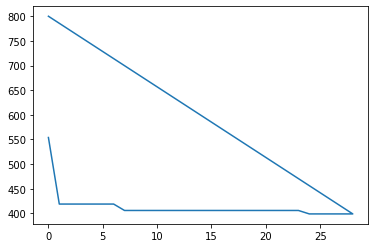

|  29       | -800.0    |  40.87    |  1.055    |  0.5875   |  0.2532   |  1.381e+0 |  3.242    |  0.2093   |  18.23    |  0.9585   |  0.5628   |  1.064    |  0.7023   |  2.39     |  6.676    |
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.32316
    momentum: 0.42
    nesterov: False
    weight_decay: 0.24
)
Batch Normalization Momentum:  0.08
Nodes:  22
LR:  0.32316
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.24
BATCH_SIZE:  31
Dropout:  0.13
Final Linear Layers:  2
average loss: 0.693401
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4810)
Class:  0  correct:  240.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5200)
Class:  1  correct:  52.0  of  tensor(100.)
Final percentage:  tensor(0.5005)
Last epoch:  22
Credit Cost:  -499


Best Score So Far:  -399


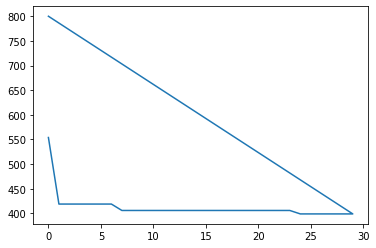

|  30       | -499.0    |  31.46    |  1.531    |  0.08066  |  0.1286   |  1.109e+0 |  2.895    |  0.3232   |  22.9     |  0.7657   |  0.2398   |  2.683    |  0.4245   |  3.464    |  4.753    |
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.02084
    weight_decay: 0.523
)
Batch Normalization Momentum:  0.02
Nodes:  24
LR:  0.02084
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.523
BATCH_SIZE:  21
Dropout:  0.02
Final Linear Layers:  1
average loss: 0.720157
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5992)
Class:  0  correct:  299.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.2900)
Class:  1  correct:  29.0  of  tensor(100.)
Final percentage:  tensor(0.4446)
Last epoch:  44
Credit Cost:  -555


Best Score So Far:  -399


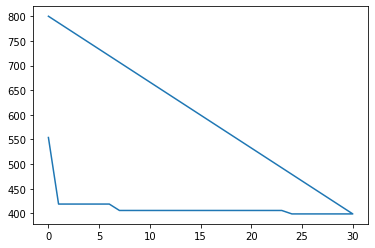

|  31       | -555.0    |  21.78    |  1.156    |  0.01815  |  0.02002  |  1.459e+0 |  1.339    |  0.02084  |  24.65    |  0.3951   |  0.5229   |  1.9      |  0.4456   |  2.429    |  3.839    |
Optimization:  Adagrad (
Parameter Group 0
    initial_accumulator_value: 0
    lr: 0.25122
    lr_decay: 0
    weight_decay: 0.002
)
Batch Normalization Momentum:  0.9
Nodes:  2
LR:  0.25122
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.002
BATCH_SIZE:  103
Dropout:  0.01
Final Linear Layers:  1
average loss: 0.693473
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.0942)
Class:  0  correct:  47.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.7900)
Class:  1  correct:  79.0  of  tensor(100.)
Final percentage:  tensor(0.4421)
Last epoch:  23
Credit Cost:  -557


Best Score So Far:  -399


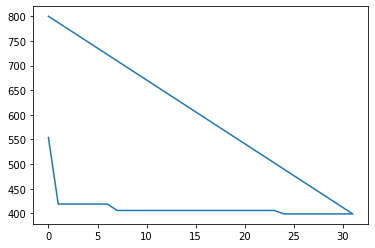

|  32       | -557.0    |  103.6    |  1.801    |  0.8956   |  0.01112  |  1.774e+0 |  1.376    |  0.2512   |  2.311    |  0.5386   |  0.002212 |  2.893    |  0.8963   |  3.38     |  6.482    |
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.28734
    rho: 0.9
    weight_decay: 0.281
)
Batch Normalization Momentum:  0.19
Nodes:  23
LR:  0.28734
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.281
BATCH_SIZE:  22
Dropout:  0.19
Final Linear Layers:  3
average loss: 0.726354
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.2585)
Class:  0  correct:  129.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5600)
Class:  1  correct:  56.0  of  tensor(100.)
Final percentage:  tensor(0.4093)
Last epoch:  45
Credit Cost:  -590


Best Score So Far:  -399


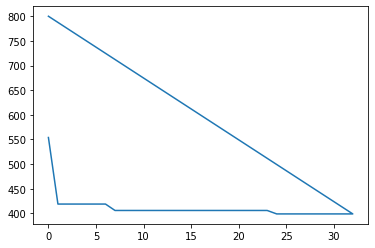

|  33       | -590.0    |  22.05    |  1.314    |  0.1858   |  0.1867   |  1.906e+0 |  3.96     |  0.2873   |  23.95    |  0.9085   |  0.2807   |  1.497    |  0.1717   |  1.357    |  5.868    |
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.21812
    weight_decay: 0.257
)
Batch Normalization Momentum:  0.81
Nodes:  11
LR:  0.21812
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.257
BATCH_SIZE:  22
Dropout:  0.09
Final Linear Layers:  1
average loss: 0.843673
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.6253)
Class:  0  correct:  312.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4600)
Class:  1  correct:  46.0  of  tensor(100.)
Final percentage:  tensor(0.5426)
Last epoch:  24
Credit Cost:  -457


Best Score So Far:  -399


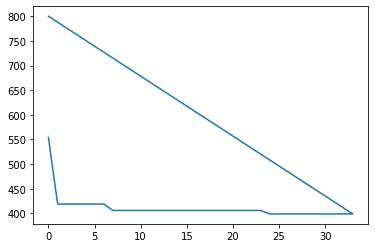

|  34       | -457.0    |  22.2     |  1.526    |  0.8109   |  0.09318  |  1.982e+0 |  1.797    |  0.2181   |  11.43    |  0.91     |  0.2567   |  1.863    |  0.5072   |  3.807    |  1.185    |
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.22782
    weight_decay: 0.44
)
Batch Normalization Momentum:  0.03
Nodes:  22
LR:  0.22782
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.44
BATCH_SIZE:  92
Dropout:  0.16
Final Linear Layers:  3
average loss: 0.681493
Class:  0  accuracy:  tensor(0.5451)
Class:  0  correct:  272.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5800)
Class:  1  correct:  58.0  of  tensor(100.)
Final percentage:  tensor(0.5625)
Last epoch:  21
Credit Cost:  -437


Best Score So Far:  -399


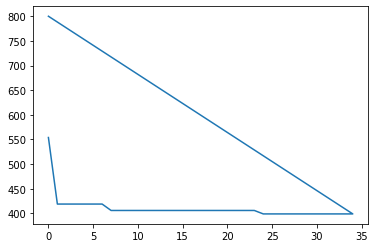

|  35       | -437.0    |  92.89    |  2.773    |  0.02701  |  0.1566   |  1.326e+0 |  3.57     |  0.2278   |  22.71    |  0.4529   |  0.4399   |  1.577    |  0.009255 |  2.725    |  2.866    |
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.37538
    weight_decay: 0.16
)
Batch Normalization Momentum:  0.42
Nodes:  27
LR:  0.37538
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.16
BATCH_SIZE:  68
Dropout:  0.07
Final Linear Layers:  3
average loss: 0.763658
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5611)
Class:  0  correct:  280.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4600)
Class:  1  correct:  46.0  of  tensor(100.)
Final percentage:  tensor(0.5106)
Last epoch:  23
Credit Cost:  -489


Best Score So Far:  -399


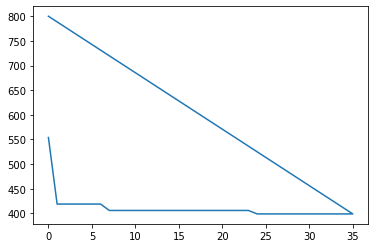

|  36       | -489.0    |  68.14    |  2.824    |  0.4222   |  0.07422  |  1.371e+0 |  3.786    |  0.3754   |  27.33    |  0.9194   |  0.1596   |  1.174    |  0.225    |  1.94     |  2.047    |
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.23395
    weight_decay: 0.16
)
Batch Normalization Momentum:  0.81
Nodes:  12
LR:  0.23395
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.16
BATCH_SIZE:  79
Dropout:  0.06
Final Linear Layers:  1
average loss: 0.681126
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.7174)
Class:  0  correct:  358.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5000)
Class:  1  correct:  50.0  of  tensor(100.)
Final percentage:  tensor(0.6087)
Last epoch:  23
Credit Cost:  -391


Best Score So Far:  -391


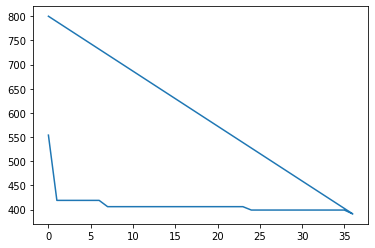

|  37       | -391.0    |  79.28    |  1.823    |  0.8082   |  0.05554  |  1.702e+0 |  1.719    |  0.2339   |  12.47    |  0.05785  |  0.1602   |  2.322    |  0.4923   |  2.552    |  2.047    |
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.24229
    weight_decay: 0.046
)
Batch Normalization Momentum:  0.81
Nodes:  2
LR:  0.24229
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.046
BATCH_SIZE:  74
Dropout:  0.18
Final Linear Layers:  3
average loss: 0.689985
Class:  0  accuracy:  tensor(0.7555)
Class:  0  correct:  377.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.1300)
Class:  1  correct:  13.0  of  tensor(100.)
Final percentage:  tensor(0.4428)
Last epoch:  21
Credit Cost:  -557


Best Score So Far:  -391


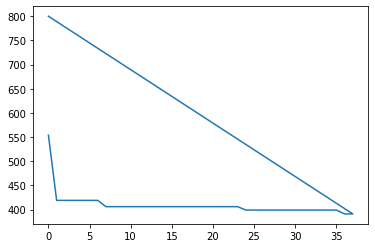

|  38       | -557.0    |  74.77    |  2.984    |  0.8087   |  0.1783   |  1.976e+0 |  3.696    |  0.2423   |  2.973    |  0.09439  |  0.04585  |  1.899    |  0.3717   |  3.916    |  2.006    |
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.01512
    weight_decay: 0.511
)
Batch Normalization Momentum:  0.82
Nodes:  12
LR:  0.01512
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.511
BATCH_SIZE:  124
Dropout:  0.19
Final Linear Layers:  2
average loss: 0.735393
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.7715)
Class:  0  correct:  385.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4300)
Class:  1  correct:  43.0  of  tensor(100.)
Final percentage:  tensor(0.6008)
Last epoch:  26
Credit Cost:  -399


Best Score So Far:  -391


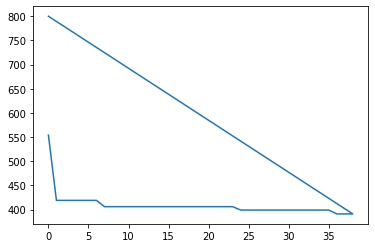

|  39       | -399.0    |  124.6    |  2.527    |  0.816    |  0.1898   |  1.669e+0 |  2.426    |  0.01512  |  12.59    |  0.4921   |  0.5111   |  1.933    |  0.4528   |  1.412    |  1.065    |
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.30441
    weight_decay: 0.219
)
Batch Normalization Momentum:  0.97
Nodes:  15
LR:  0.30441
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.219
BATCH_SIZE:  98
Dropout:  0.07
Final Linear Layers:  2
average loss: 0.683867
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4729)
Class:  0  correct:  236.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6600)
Class:  1  correct:  66.0  of  tensor(100.)
Final percentage:  tensor(0.5665)
Last epoch:  25
Credit Cost:  -433


Best Score So Far:  -391


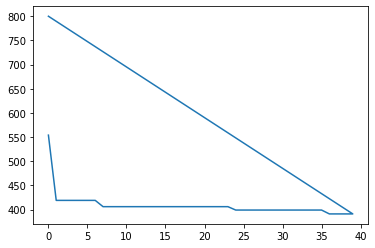

|  40       | -433.0    |  98.03    |  1.637    |  0.9745   |  0.06607  |  1.339e+0 |  2.566    |  0.3044   |  15.92    |  0.1256   |  0.2188   |  2.004    |  0.6671   |  3.303    |  1.781    |
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.18521
    momentum: 0.85
    nesterov: False
    weight_decay: 0.004
)
Batch Normalization Momentum:  0.8
Nodes:  29
LR:  0.18521
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.004
BATCH_SIZE:  6
Dropout:  0.0
Final Linear Layers:  3
average loss: 3.103056
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.3948)
Class:  0  correct:  197.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4600)
Class:  1  correct:  46.0  of  tensor(100.)
Final percentage:  tensor(0.4274)
Last epoch:  36
Credit Cost:  -572


Best Score So Far:  -391


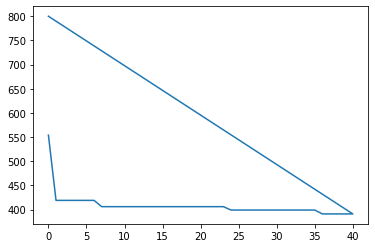

|  41       | -572.0    |  6.841    |  2.033    |  0.8019   |  0.003781 |  1.672e+0 |  3.054    |  0.1852   |  29.44    |  0.6441   |  0.003767 |  1.964    |  0.8507   |  3.483    |  4.888    |
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.34377
    weight_decay: 0.203
)
Batch Normalization Momentum:  0.27
Nodes:  7
LR:  0.34377
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.203
BATCH_SIZE:  87
Dropout:  0.17
Final Linear Layers:  2
average loss: 0.683181
Class:  0  accuracy:  tensor(0.6834)
Class:  0  correct:  341.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4500)
Class:  1  correct:  45.0  of  tensor(100.)
Final percentage:  tensor(0.5667)
Last epoch:  21
Credit Cost:  -433


Best Score So Far:  -391


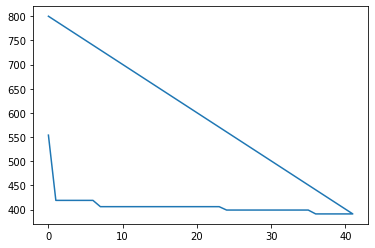

|  42       | -433.0    |  87.54    |  2.151    |  0.2714   |  0.1682   |  1.672e+0 |  2.054    |  0.3438   |  7.851    |  0.7468   |  0.2028   |  2.54     |  0.4235   |  3.415    |  3.118    |
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.0935
    rho: 0.9
    weight_decay: 0.264
)
Batch Normalization Momentum:  0.31
Nodes:  7
LR:  0.0935
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.264
BATCH_SIZE:  30
Dropout:  0.22
Final Linear Layers:  1
average loss: 0.732757
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4248)
Class:  0  correct:  212.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4500)
Class:  1  correct:  45.0  of  tensor(100.)
Final percentage:  tensor(0.4374)
Last epoch:  64
Credit Cost:  -562


Best Score So Far:  -391


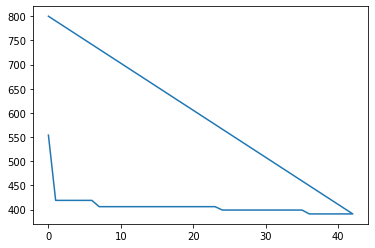

|  43       | -562.0    |  30.5     |  2.527    |  0.3056   |  0.22     |  1.744e+0 |  1.662    |  0.0935   |  7.968    |  0.1432   |  0.264    |  1.053    |  0.1098   |  3.017    |  5.791    |
Optimization:  Adagrad (
Parameter Group 0
    initial_accumulator_value: 0
    lr: 0.12876
    lr_decay: 0
    weight_decay: 0.646
)
Batch Normalization Momentum:  0.21
Nodes:  27
LR:  0.12876
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.646
BATCH_SIZE:  13
Dropout:  0.28
Final Linear Layers:  2
average loss: 0.693147
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  21
Credit Cost:  -800


Best Score So Far:  -391


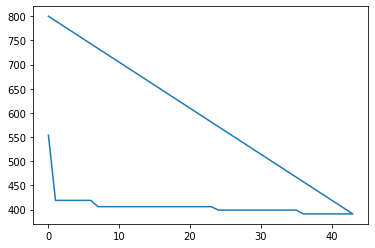

|  44       | -800.0    |  13.99    |  1.461    |  0.2055   |  0.2752   |  1.711e+0 |  2.656    |  0.1288   |  27.05    |  0.4354   |  0.6464   |  2.405    |  0.4733   |  1.377    |  6.847    |
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.08361
    momentum: 0.74
    nesterov: False
    weight_decay: 0.148
)
Batch Normalization Momentum:  0.43
Nodes:  21
LR:  0.08361
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.148
BATCH_SIZE:  23
Dropout:  0.12
Final Linear Layers:  3
average loss: 0.681684
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  21
Credit Cost:  -800


Best Score So Far:  -391


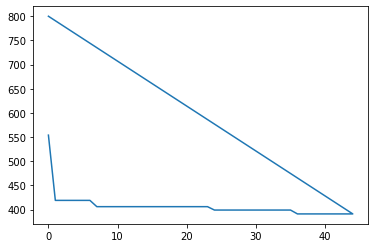

|  45       | -800.0    |  23.82    |  1.403    |  0.4269   |  0.1213   |  1.147e+0 |  3.181    |  0.08361  |  21.32    |  0.7538   |  0.1476   |  2.196    |  0.7414   |  2.908    |  4.577    |
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.33576
    momentum: 0.9
    nesterov: False
    weight_decay: 0.21
)
Batch Normalization Momentum:  0.94
Nodes:  7
LR:  0.33576
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.21
BATCH_SIZE:  40
Dropout:  0.13
Final Linear Layers:  1
average loss: 0.693147
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.3387)
Class:  0  correct:  169.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.8100)
Class:  1  correct:  81.0  of  tensor(100.)
Final percentage:  tensor(0.5743)
Last epoch:  22
Credit Cost:  -425


Best Score So Far:  -391


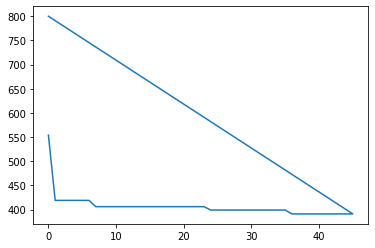

|  46       | -425.0    |  40.64    |  2.456    |  0.9359   |  0.1277   |  1.782e+0 |  1.168    |  0.3358   |  7.768    |  0.3953   |  0.2101   |  1.159    |  0.8956   |  2.107    |  4.179    |
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.14925
    weight_decay: 0.075
)
Batch Normalization Momentum:  0.2
Nodes:  5
LR:  0.14925
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.075
BATCH_SIZE:  65
Dropout:  0.02
Final Linear Layers:  1
average loss: 0.691857
Class:  0  accuracy:  tensor(0.4749)
Class:  0  correct:  237.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5100)
Class:  1  correct:  51.0  of  tensor(100.)
Final percentage:  tensor(0.4925)
Last epoch:  21
Credit Cost:  -507


Best Score So Far:  -391


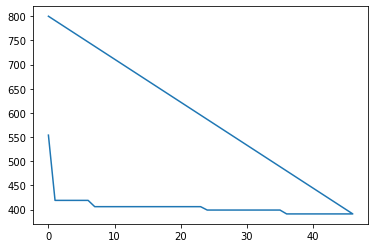

|  47       | -507.0    |  65.27    |  1.263    |  0.2044   |  0.02286  |  1.508e+0 |  1.782    |  0.1493   |  5.242    |  0.787    |  0.0747   |  2.962    |  0.1754   |  2.711    |  1.269    |
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.09448
    momentum: 0.02
    nesterov: False
    weight_decay: 0.124
)
Batch Normalization Momentum:  0.52
Nodes:  24
LR:  0.09448
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.124
BATCH_SIZE:  101
Dropout:  0.22
Final Linear Layers:  2
average loss: 0.695471
Class:  0  accuracy:  tensor(0.5752)
Class:  0  correct:  287.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4400)
Class:  1  correct:  44.0  of  tensor(100.)
Final percentage:  tensor(0.5076)
Last epoch:  21
Credit Cost:  -492


Best Score So Far:  -391


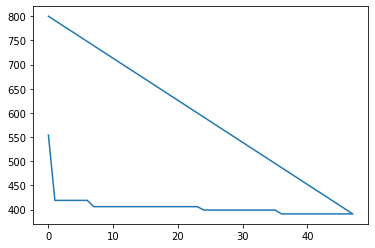

|  48       | -492.0    |  101.6    |  1.377    |  0.5226   |  0.222    |  1.15e+03 |  2.648    |  0.09448  |  24.78    |  0.7225   |  0.1237   |  2.715    |  0.01958  |  3.572    |  4.348    |
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.37422
    rho: 0.9
    weight_decay: 0.362
)
Batch Normalization Momentum:  0.71
Nodes:  27
LR:  0.37422
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.362
BATCH_SIZE:  53
Dropout:  0.3
Final Linear Layers:  1
average loss: 0.690635
Class:  0  accuracy:  tensor(0.3768)
Class:  0  correct:  188.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.7000)
Class:  1  correct:  70.0  of  tensor(100.)
Final percentage:  tensor(0.5384)
Last epoch:  21
Credit Cost:  -461


Best Score So Far:  -391


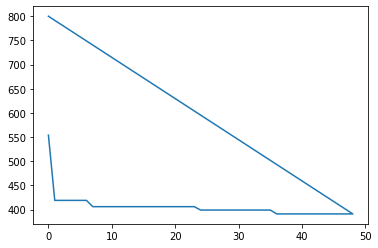

|  49       | -461.0    |  54.0     |  2.51     |  0.7098   |  0.2962   |  1.278e+0 |  1.011    |  0.3742   |  27.74    |  0.7284   |  0.3617   |  2.407    |  0.7727   |  2.121    |  5.614    |
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.3596
    weight_decay: 0.154
)
Batch Normalization Momentum:  0.4
Nodes:  9
LR:  0.3596
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.154
BATCH_SIZE:  97
Dropout:  0.21
Final Linear Layers:  3
average loss: 0.692298
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4569)
Class:  0  correct:  228.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5800)
Class:  1  correct:  58.0  of  tensor(100.)
Final percentage:  tensor(0.5185)
Last epoch:  26
Credit Cost:  -481


Best Score So Far:  -391


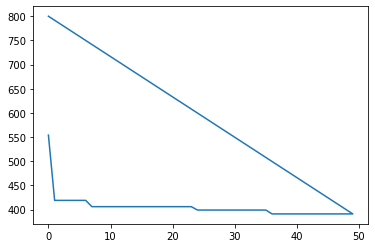

|  50       | -481.0    |  97.08    |  2.22     |  0.3978   |  0.2092   |  1.003e+0 |  3.317    |  0.3596   |  9.179    |  0.1215   |  0.1543   |  1.601    |  0.8742   |  2.624    |  2.717    |
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.19337
    weight_decay: 0.393
)
Batch Normalization Momentum:  0.68
Nodes:  12
LR:  0.19337
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.393
BATCH_SIZE:  77
Dropout:  0.04
Final Linear Layers:  2
average loss: 0.696000
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.7214)
Class:  0  correct:  360.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3800)
Class:  1  correct:  38.0  of  tensor(100.)
Final percentage:  tensor(0.5507)
Last epoch:  23
Credit Cost:  -449


Best Score So Far:  -391


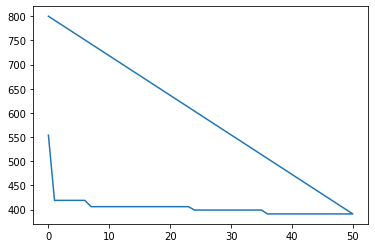

|  51       | -449.0    |  77.61    |  2.71     |  0.6786   |  0.03907  |  1.7e+03  |  2.512    |  0.1934   |  12.86    |  0.5488   |  0.3935   |  2.379    |  0.6338   |  3.755    |  1.629    |
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.28857
    weight_decay: 0.166
)
Batch Normalization Momentum:  0.29
Nodes:  11
LR:  0.28857
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.166
BATCH_SIZE:  82
Dropout:  0.16
Final Linear Layers:  1
average loss: 0.701798
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5491)
Class:  0  correct:  274.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6100)
Class:  1  correct:  61.0  of  tensor(100.)
Final percentage:  tensor(0.5795)
Last epoch:  23
Credit Cost:  -420


Best Score So Far:  -391


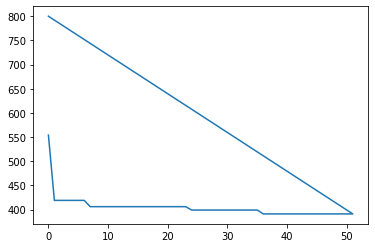

|  52       | -420.0    |  82.55    |  1.142    |  0.2862   |  0.1596   |  1.704e+0 |  1.604    |  0.2886   |  11.96    |  0.7945   |  0.1661   |  2.565    |  0.8965   |  3.512    |  2.074    |
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.1792
    weight_decay: 0.4
)
Batch Normalization Momentum:  0.07
Nodes:  12
LR:  0.1792
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.4
BATCH_SIZE:  79
Dropout:  0.28
Final Linear Layers:  2
average loss: 0.688148
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  21
Credit Cost:  -800


Best Score So Far:  -391


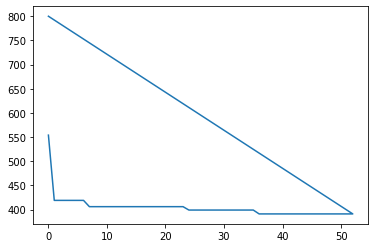

|  53       | -800.0    |  79.15    |  2.17     |  0.07406  |  0.2782   |  1.703e+0 |  2.806    |  0.1792   |  12.02    |  0.1008   |  0.3995   |  1.76     |  0.1526   |  2.525    |  2.883    |
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.03577
    weight_decay: 0.426
)
Batch Normalization Momentum:  0.77
Nodes:  10
LR:  0.03577
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.426
BATCH_SIZE:  53
Dropout:  0.21
Final Linear Layers:  3
average loss: 0.816518
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.2665)
Class:  0  correct:  133.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6300)
Class:  1  correct:  63.0  of  tensor(100.)
Final percentage:  tensor(0.4483)
Last epoch:  68
Credit Cost:  -551


Best Score So Far:  -391


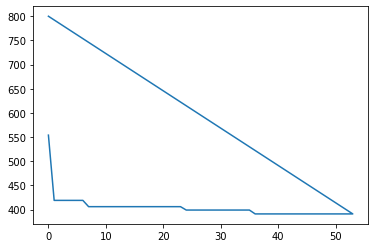

|  54       | -551.0    |  53.84    |  1.895    |  0.7701   |  0.2138   |  1.943e+0 |  3.74     |  0.03577  |  10.55    |  0.9175   |  0.4255   |  1.359    |  0.152    |  1.012    |  3.674    |
Optimization:  Adagrad (
Parameter Group 0
    initial_accumulator_value: 0
    lr: 0.282
    lr_decay: 0
    weight_decay: 0.555
)
Batch Normalization Momentum:  0.13
Nodes:  8
LR:  0.282
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.555
BATCH_SIZE:  10
Dropout:  0.13
Final Linear Layers:  2
average loss: 0.693147
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  21
Credit Cost:  -800


Best Score So Far:  -391


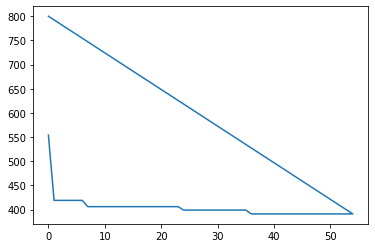

|  55       | -800.0    |  10.72    |  2.122    |  0.1262   |  0.1328   |  1.516e+0 |  2.93     |  0.282    |  8.58     |  0.8079   |  0.5552   |  2.536    |  0.7674   |  1.291    |  6.675    |
Optimization:  Adagrad (
Parameter Group 0
    initial_accumulator_value: 0
    lr: 0.03653
    lr_decay: 0
    weight_decay: 0.294
)
Batch Normalization Momentum:  0.69
Nodes:  12
LR:  0.03653
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.294
BATCH_SIZE:  76
Dropout:  0.2
Final Linear Layers:  1
average loss: 0.693455
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5792)
Class:  0  correct:  289.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4200)
Class:  1  correct:  42.0  of  tensor(100.)
Final percentage:  tensor(0.4996)
Last epoch:  26
Credit Cost:  -500


Best Score So Far:  -391


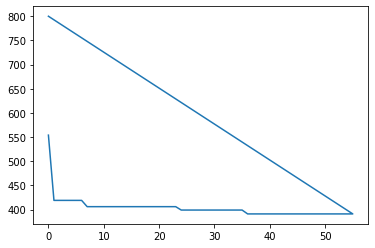

|  56       | -500.0    |  76.21    |  2.13     |  0.6859   |  0.2044   |  1.439e+0 |  1.027    |  0.03653  |  12.62    |  0.06032  |  0.2941   |  1.048    |  0.03752  |  3.093    |  6.075    |
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.39441
    rho: 0.9
    weight_decay: 0.032
)
Batch Normalization Momentum:  0.72
Nodes:  21
LR:  0.39441
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.032
BATCH_SIZE:  123
Dropout:  0.09
Final Linear Layers:  3
average loss: 0.691698
Class:  0  accuracy:  tensor(0.5210)
Class:  0  correct:  260.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3600)
Class:  1  correct:  36.0  of  tensor(100.)
Final percentage:  tensor(0.4405)
Last epoch:  21
Credit Cost:  -559


Best Score So Far:  -391


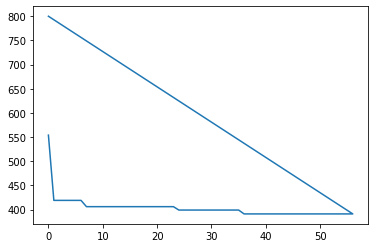

|  57       | -559.0    |  123.1    |  2.926    |  0.7205   |  0.08972  |  1.373e+0 |  3.853    |  0.3944   |  21.35    |  0.1345   |  0.0322   |  2.269    |  0.5178   |  1.256    |  5.465    |
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.09199
    weight_decay: 0.198
)
Batch Normalization Momentum:  0.32
Nodes:  15
LR:  0.09199
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.198
BATCH_SIZE:  112
Dropout:  0.18
Final Linear Layers:  1
average loss: 0.693469
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.3928)
Class:  0  correct:  196.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.7600)
Class:  1  correct:  76.0  of  tensor(100.)
Final percentage:  tensor(0.5764)
Last epoch:  34
Credit Cost:  -423


Best Score So Far:  -391


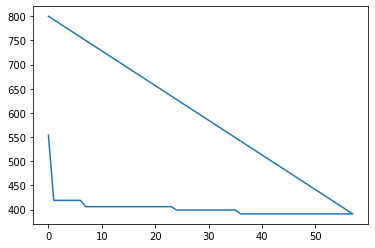

|  58       | -423.0    |  112.2    |  2.19     |  0.3194   |  0.1774   |  1.008e+0 |  1.241    |  0.09199  |  15.93    |  0.1175   |  0.1982   |  1.102    |  0.6599   |  3.984    |  3.449    |
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.17066
    rho: 0.9
    weight_decay: 0.087
)
Batch Normalization Momentum:  0.72
Nodes:  19
LR:  0.17066
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.087
BATCH_SIZE:  113
Dropout:  0.21
Final Linear Layers:  3
average loss: 0.722893
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4389)
Class:  0  correct:  219.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5100)
Class:  1  correct:  51.0  of  tensor(100.)
Final percentage:  tensor(0.4744)
Last epoch:  36
Credit Cost:  -525


Best Score So Far:  -391


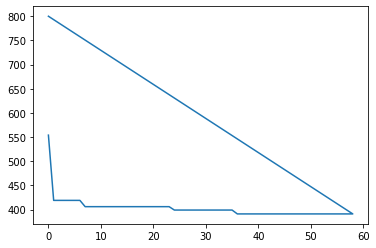

|  59       | -525.0    |  113.9    |  1.909    |  0.7168   |  0.2095   |  1.501e+0 |  3.571    |  0.1707   |  19.98    |  0.08331  |  0.08658  |  2.418    |  0.003299 |  1.848    |  5.523    |
Optimization:  Adagrad (
Parameter Group 0
    initial_accumulator_value: 0
    lr: 0.36891
    lr_decay: 0
    weight_decay: 0.299
)
Batch Normalization Momentum:  0.09
Nodes:  22
LR:  0.36891
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.299
BATCH_SIZE:  51
Dropout:  0.07
Final Linear Layers:  3
average loss: 0.693147
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  21
Credit Cost:  -800


Best Score So Far:  -391


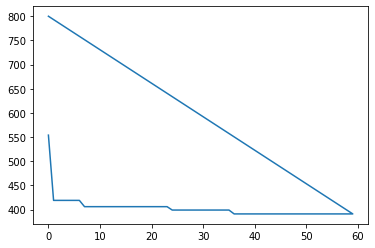

|  60       | -800.0    |  51.83    |  1.952    |  0.08666  |  0.07221  |  1.731e+0 |  3.146    |  0.3689   |  22.36    |  0.06661  |  0.2994   |  2.221    |  0.9294   |  1.518    |  6.187    |
Optimization:  Adagrad (
Parameter Group 0
    initial_accumulator_value: 0
    lr: 0.35228
    lr_decay: 0
    weight_decay: 0.414
)
Batch Normalization Momentum:  0.76
Nodes:  9
LR:  0.35228
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.414
BATCH_SIZE:  122
Dropout:  0.18
Final Linear Layers:  1
average loss: 0.693388
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.3747)
Class:  0  correct:  187.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5200)
Class:  1  correct:  52.0  of  tensor(100.)
Final percentage:  tensor(0.4474)
Last epoch:  22
Credit Cost:  -552


Best Score So Far:  -391


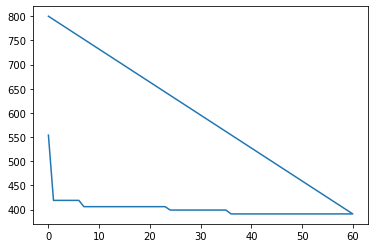

|  61       | -552.0    |  122.4    |  2.439    |  0.7571   |  0.1754   |  1.767e+0 |  1.351    |  0.3523   |  9.029    |  0.4139   |  0.4137   |  1.263    |  0.554    |  3.703    |  6.104    |
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.08041
    momentum: 0.77
    nesterov: False
    weight_decay: 0.649
)
Batch Normalization Momentum:  0.26
Nodes:  14
LR:  0.08041
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.649
BATCH_SIZE:  111
Dropout:  0.16
Final Linear Layers:  2
average loss: 0.748008
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.6152)
Class:  0  correct:  307.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4400)
Class:  1  correct:  44.0  of  tensor(100.)
Final percentage:  tensor(0.5276)
Last epoch:  24
Credit Cost:  -472


Best Score So Far:  -391


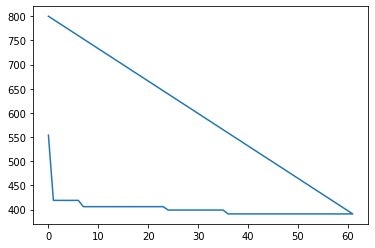

|  62       | -472.0    |  111.4    |  2.51     |  0.2618   |  0.1591   |  1.535e+0 |  2.436    |  0.08041  |  14.85    |  0.08063  |  0.6494   |  1.44     |  0.7748   |  2.653    |  4.718    |
Optimization:  Adagrad (
Parameter Group 0
    initial_accumulator_value: 0
    lr: 0.2479
    lr_decay: 0
    weight_decay: 0.121
)
Batch Normalization Momentum:  0.97
Nodes:  3
LR:  0.2479
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.121
BATCH_SIZE:  58
Dropout:  0.2
Final Linear Layers:  3
average loss: 0.693147
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  21
Credit Cost:  -800


Best Score So Far:  -391


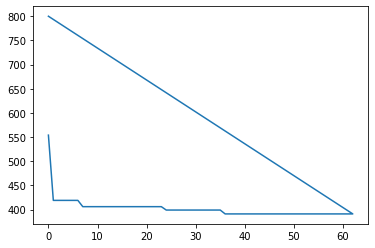

|  63       | -800.0    |  58.83    |  1.0      |  0.9677   |  0.1983   |  1.132e+0 |  3.41     |  0.2479   |  3.869    |  0.2794   |  0.1213   |  1.202    |  0.1644   |  1.168    |  6.119    |
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.01162
    weight_decay: 0.292
)
Batch Normalization Momentum:  0.04
Nodes:  4
LR:  0.01162
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.292
BATCH_SIZE:  54
Dropout:  0.19
Final Linear Layers:  1
average loss: 0.692893
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  21
Credit Cost:  -800


Best Score So Far:  -391


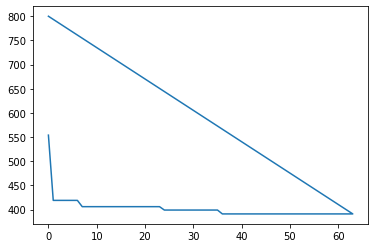

|  64       | -800.0    |  54.4     |  1.754    |  0.04308  |  0.1863   |  1.436e+0 |  1.824    |  0.01162  |  4.252    |  0.9732   |  0.2919   |  2.674    |  0.4049   |  2.378    |  2.062    |
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.26852
    weight_decay: 0.604
)
Batch Normalization Momentum:  0.16
Nodes:  10
LR:  0.26852
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.604
BATCH_SIZE:  47
Dropout:  0.1
Final Linear Layers:  1
average loss: 0.692317
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  21
Credit Cost:  -800


Best Score So Far:  -391


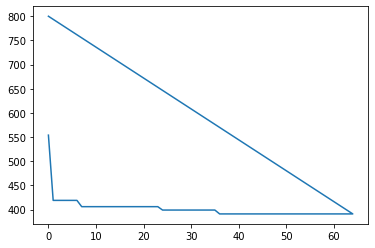

|  65       | -800.0    |  47.33    |  1.885    |  0.1596   |  0.1019   |  1.365e+0 |  1.985    |  0.2685   |  10.33    |  0.425    |  0.6035   |  1.834    |  0.6272   |  1.467    |  3.184    |
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.15104
    weight_decay: 0.182
)
Batch Normalization Momentum:  0.88
Nodes:  29
LR:  0.15104
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.182
BATCH_SIZE:  68
Dropout:  0.21
Final Linear Layers:  1
average loss: 0.658336
Class:  0  accuracy:  tensor(0.6573)
Class:  0  correct:  328.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4500)
Class:  1  correct:  45.0  of  tensor(100.)
Final percentage:  tensor(0.5537)
Last epoch:  21
Credit Cost:  -446


Best Score So Far:  -391


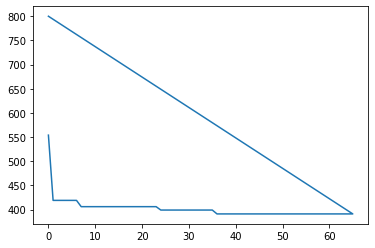

|  66       | -446.0    |  68.7     |  1.871    |  0.8755   |  0.2113   |  1.725e+0 |  1.128    |  0.151    |  29.8     |  0.2024   |  0.1824   |  1.144    |  0.8144   |  1.061    |  2.0      |
Optimization:  Adagrad (
Parameter Group 0
    initial_accumulator_value: 0
    lr: 0.38847
    lr_decay: 0
    weight_decay: 0.353
)
Batch Normalization Momentum:  0.74
Nodes:  16
LR:  0.38847
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.353
BATCH_SIZE:  119
Dropout:  0.14
Final Linear Layers:  3
average loss: 0.694123
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.2625)
Class:  0  correct:  131.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5500)
Class:  1  correct:  55.0  of  tensor(100.)
Final percentage:  tensor(0.4063)
Last epoch:  22
Credit Cost:  -593


Best Score So Far:  -391


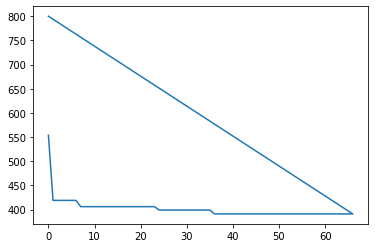

|  67       | -593.0    |  119.8    |  2.531    |  0.7351   |  0.1436   |  1.737e+0 |  3.31     |  0.3885   |  16.95    |  0.322    |  0.3531   |  2.169    |  0.2392   |  1.278    |  6.672    |
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.38546
    momentum: 0.4
    nesterov: False
    weight_decay: 0.443
)
Batch Normalization Momentum:  0.94
Nodes:  17
LR:  0.38546
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.443
BATCH_SIZE:  109
Dropout:  0.16
Final Linear Layers:  3
average loss: 0.687388
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  21
Credit Cost:  -800


Best Score So Far:  -391


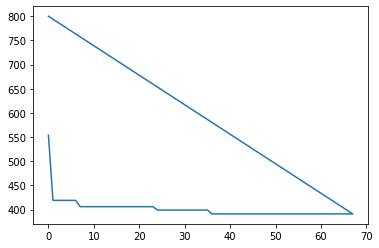

|  68       | -800.0    |  109.6    |  2.51     |  0.9404   |  0.1637   |  1.342e+0 |  3.47     |  0.3855   |  17.06    |  0.2111   |  0.4433   |  2.297    |  0.403    |  1.918    |  4.092    |
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.16396
    weight_decay: 0.422
)
Batch Normalization Momentum:  0.58
Nodes:  19
LR:  0.16396
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.422
BATCH_SIZE:  99
Dropout:  0.27
Final Linear Layers:  1
average loss: 0.708484
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4269)
Class:  0  correct:  213.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4200)
Class:  1  correct:  42.0  of  tensor(100.)
Final percentage:  tensor(0.4234)
Last epoch:  42
Credit Cost:  -576


Best Score So Far:  -391


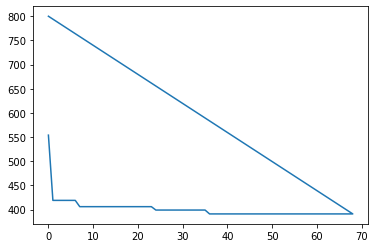

|  69       | -576.0    |  99.27    |  1.439    |  0.5759   |  0.2744   |  1.425e+0 |  1.849    |  0.164    |  19.46    |  0.733    |  0.4216   |  2.482    |  0.4878   |  2.518    |  3.018    |
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.32893
    weight_decay: 0.656
)
Batch Normalization Momentum:  0.4
Nodes:  25
LR:  0.32893
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.656
BATCH_SIZE:  67
Dropout:  0.13
Final Linear Layers:  3
average loss: 0.691801
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  21
Credit Cost:  -800


Best Score So Far:  -391


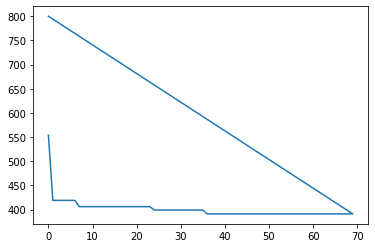

|  70       | -800.0    |  67.32    |  1.607    |  0.397    |  0.129    |  1.454e+0 |  3.194    |  0.3289   |  25.1     |  0.6743   |  0.656    |  1.307    |  0.7179   |  3.882    |  3.5      |
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.29512
    momentum: 0.81
    nesterov: False
    weight_decay: 0.47
)
Batch Normalization Momentum:  0.77
Nodes:  30
LR:  0.29512
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.47
BATCH_SIZE:  45
Dropout:  0.21
Final Linear Layers:  2
average loss: 0.692866
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4028)
Class:  0  correct:  201.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6300)
Class:  1  correct:  63.0  of  tensor(100.)
Final percentage:  tensor(0.5164)
Last epoch:  23
Credit Cost:  -483


Best Score So Far:  -391


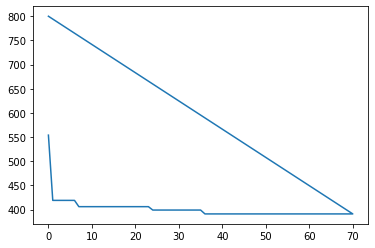

|  71       | -483.0    |  45.52    |  1.131    |  0.768    |  0.2063   |  1.604e+0 |  2.018    |  0.2951   |  30.09    |  0.9071   |  0.4696   |  1.311    |  0.808    |  2.332    |  4.512    |
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.17588
    weight_decay: 0.361
)
Batch Normalization Momentum:  0.79
Nodes:  15
LR:  0.17588
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.361
BATCH_SIZE:  44
Dropout:  0.23
Final Linear Layers:  2
average loss: 0.695634
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.6794)
Class:  0  correct:  339.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3900)
Class:  1  correct:  39.0  of  tensor(100.)
Final percentage:  tensor(0.5347)
Last epoch:  22
Credit Cost:  -465


Best Score So Far:  -391


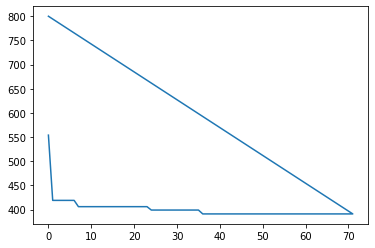

|  72       | -465.0    |  44.71    |  2.337    |  0.7869   |  0.2264   |  1.437e+0 |  2.493    |  0.1759   |  15.04    |  0.1399   |  0.3609   |  2.367    |  0.4899   |  1.245    |  2.464    |
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.13958
    weight_decay: 0.424
)
Batch Normalization Momentum:  0.96
Nodes:  5
LR:  0.13958
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.424
BATCH_SIZE:  11
Dropout:  0.12
Final Linear Layers:  2
average loss: 0.688503
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  21
Credit Cost:  -800


Best Score So Far:  -391


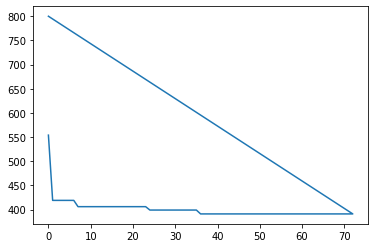

|  73       | -800.0    |  11.96    |  1.623    |  0.9636   |  0.1164   |  1.207e+0 |  2.734    |  0.1396   |  5.881    |  0.3331   |  0.4241   |  1.458    |  0.8574   |  1.144    |  3.262    |
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.29562
    weight_decay: 0.108
)
Batch Normalization Momentum:  0.1
Nodes:  3
LR:  0.29562
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.108
BATCH_SIZE:  16
Dropout:  0.06
Final Linear Layers:  2
average loss: 0.693140
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.6854)
Class:  0  correct:  342.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3500)
Class:  1  correct:  35.0  of  tensor(100.)
Final percentage:  tensor(0.5177)
Last epoch:  22
Credit Cost:  -482


Best Score So Far:  -391


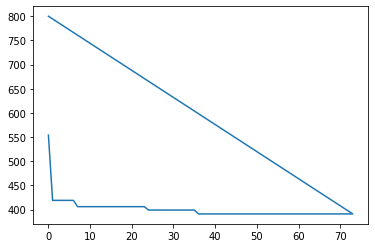

|  74       | -482.0    |  16.44    |  2.921    |  0.1005   |  0.06181  |  1.593e+0 |  2.939    |  0.2956   |  3.805    |  0.6629   |  0.1084   |  1.057    |  0.6549   |  3.885    |  1.812    |
Optimization:  Adagrad (
Parameter Group 0
    initial_accumulator_value: 0
    lr: 0.18346
    lr_decay: 0
    weight_decay: 0.519
)
Batch Normalization Momentum:  0.53
Nodes:  25
LR:  0.18346
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.519
BATCH_SIZE:  96
Dropout:  0.16
Final Linear Layers:  2
average loss: 0.692833
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  21
Credit Cost:  -800


Best Score So Far:  -391


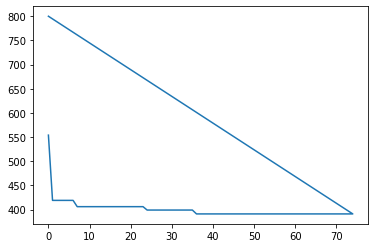

|  75       | -800.0    |  96.87    |  2.623    |  0.5344   |  0.1634   |  1.916e+0 |  2.576    |  0.1835   |  25.49    |  0.7044   |  0.5194   |  1.784    |  0.2014   |  2.121    |  6.359    |
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.20955
    weight_decay: 0.656
)
Batch Normalization Momentum:  0.83
Nodes:  18
LR:  0.20955
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.656
BATCH_SIZE:  114
Dropout:  0.22
Final Linear Layers:  1
average loss: 0.698710
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.6413)
Class:  0  correct:  320.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5500)
Class:  1  correct:  55.0  of  tensor(100.)
Final percentage:  tensor(0.5956)
Last epoch:  28
Credit Cost:  -404


Best Score So Far:  -391


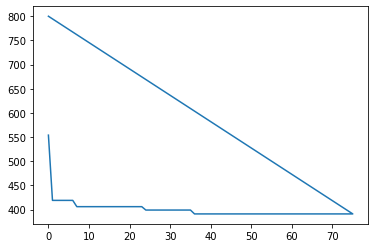

|  76       | -404.0    |  114.4    |  2.748    |  0.8299   |  0.2249   |  1.402e+0 |  1.843    |  0.2096   |  18.96    |  0.4189   |  0.6557   |  2.184    |  0.2142   |  2.022    |  2.203    |
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.25824
    weight_decay: 0.217
)
Batch Normalization Momentum:  0.81
Nodes:  13
LR:  0.25824
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.217
BATCH_SIZE:  119
Dropout:  0.02
Final Linear Layers:  1
average loss: 0.757999
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.2665)
Class:  0  correct:  133.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6000)
Class:  1  correct:  60.0  of  tensor(100.)
Final percentage:  tensor(0.4333)
Last epoch:  52
Credit Cost:  -566


Best Score So Far:  -391


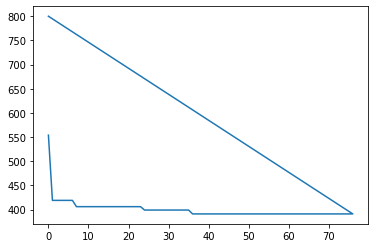

|  77       | -566.0    |  119.1    |  2.519    |  0.8106   |  0.02091  |  1.418e+0 |  1.303    |  0.2582   |  13.01    |  0.9763   |  0.2168   |  1.009    |  0.4163   |  3.551    |  3.762    |
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.16174
    rho: 0.9
    weight_decay: 0.467
)
Batch Normalization Momentum:  0.09
Nodes:  10
LR:  0.16174
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.467
BATCH_SIZE:  106
Dropout:  0.1
Final Linear Layers:  2
average loss: 0.754679
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.6954)
Class:  0  correct:  347.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4400)
Class:  1  correct:  44.0  of  tensor(100.)
Final percentage:  tensor(0.5677)
Last epoch:  85
Credit Cost:  -432


Best Score So Far:  -391


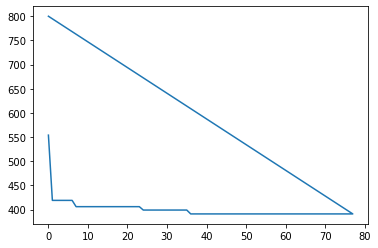

|  78       | -432.0    |  106.3    |  1.208    |  0.0912   |  0.1035   |  1.758e+0 |  2.092    |  0.1617   |  10.15    |  0.8505   |  0.4671   |  2.452    |  0.5962   |  3.151    |  5.173    |
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.29626
    momentum: 0.32
    nesterov: False
    weight_decay: 0.583
)
Batch Normalization Momentum:  0.22
Nodes:  7
LR:  0.29626
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.583
BATCH_SIZE:  113
Dropout:  0.17
Final Linear Layers:  2
average loss: 0.689056
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  21
Credit Cost:  -800


Best Score So Far:  -391


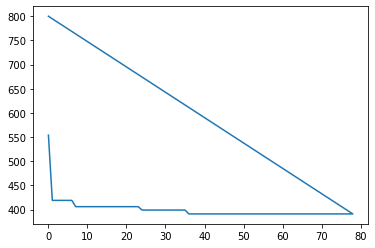

|  79       | -800.0    |  113.1    |  2.95     |  0.2187   |  0.1658   |  1.243e+0 |  2.535    |  0.2963   |  7.032    |  0.5446   |  0.5831   |  1.751    |  0.3225   |  1.919    |  4.17     |
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.01163
    weight_decay: 0.38
)
Batch Normalization Momentum:  0.62
Nodes:  18
LR:  0.01163
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.38
BATCH_SIZE:  118
Dropout:  0.13
Final Linear Layers:  1
average loss: 0.698532
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.7675)
Class:  0  correct:  383.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4200)
Class:  1  correct:  42.0  of  tensor(100.)
Final percentage:  tensor(0.5938)
Last epoch:  38
Credit Cost:  -406


Best Score So Far:  -391


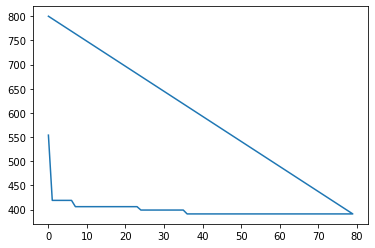

|  80       | -406.0    |  118.4    |  2.657    |  0.6237   |  0.1272   |  1.652e+0 |  1.099    |  0.01163  |  18.4     |  0.3179   |  0.3796   |  2.306    |  0.93     |  3.048    |  1.64     |
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.11364
    rho: 0.9
    weight_decay: 0.245
)
Batch Normalization Momentum:  0.11
Nodes:  8
LR:  0.11364
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.245
BATCH_SIZE:  65
Dropout:  0.17
Final Linear Layers:  3
average loss: 0.680722
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5832)
Class:  0  correct:  291.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5300)
Class:  1  correct:  53.0  of  tensor(100.)
Final percentage:  tensor(0.5566)
Last epoch:  24
Credit Cost:  -443


Best Score So Far:  -391


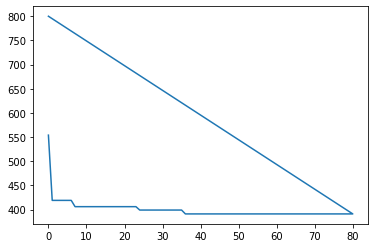

|  81       | -443.0    |  65.42    |  1.57     |  0.1134   |  0.1726   |  1.797e+0 |  3.289    |  0.1136   |  8.146    |  0.8519   |  0.2447   |  1.765    |  0.5826   |  1.962    |  5.735    |
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.33149
    weight_decay: 0.526
)
Batch Normalization Momentum:  0.3
Nodes:  7
LR:  0.33149
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.526
BATCH_SIZE:  118
Dropout:  0.19
Final Linear Layers:  1
average loss: 0.698236
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.4830)
Class:  0  correct:  241.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.3400)
Class:  1  correct:  34.0  of  tensor(100.)
Final percentage:  tensor(0.4115)
Last epoch:  26
Credit Cost:  -588


Best Score So Far:  -391


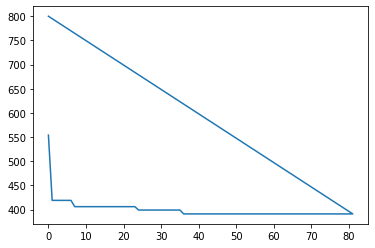

|  82       | -588.0    |  118.0    |  1.589    |  0.2959   |  0.1945   |  1.435e+0 |  1.778    |  0.3315   |  7.264    |  0.9462   |  0.5257   |  2.585    |  0.7185   |  2.275    |  3.006    |
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.2544
    weight_decay: 0.679
)
Batch Normalization Momentum:  0.29
Nodes:  25
LR:  0.2544
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.679
BATCH_SIZE:  110
Dropout:  0.27
Final Linear Layers:  2
average loss: 0.693803
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.3106)
Class:  0  correct:  155.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6600)
Class:  1  correct:  66.0  of  tensor(100.)
Final percentage:  tensor(0.4853)
Last epoch:  22
Credit Cost:  -514


Best Score So Far:  -391


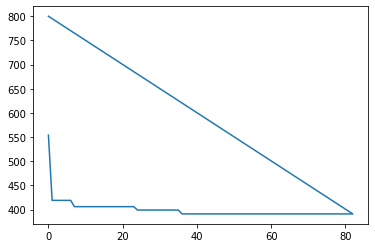

|  83       | -514.0    |  110.1    |  1.888    |  0.2871   |  0.2668   |  1.701e+0 |  2.43     |  0.2544   |  25.01    |  0.1602   |  0.6792   |  2.425    |  0.9799   |  2.422    |  3.949    |
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.10278
    weight_decay: 0.567
)
Batch Normalization Momentum:  0.83
Nodes:  17
LR:  0.10278
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.567
BATCH_SIZE:  39
Dropout:  0.1
Final Linear Layers:  1
average loss: 0.697478
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5531)
Class:  0  correct:  276.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5500)
Class:  1  correct:  55.0  of  tensor(100.)
Final percentage:  tensor(0.5516)
Last epoch:  22
Credit Cost:  -448


Best Score So Far:  -391


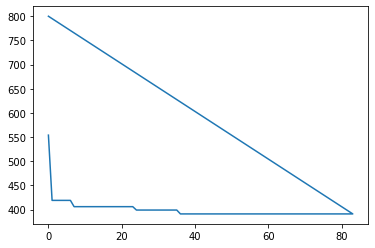

|  84       | -448.0    |  39.5     |  2.3      |  0.8297   |  0.0958   |  1.741e+0 |  1.497    |  0.1028   |  17.17    |  0.4282   |  0.5668   |  2.073    |  0.2844   |  2.358    |  2.399    |
Optimization:  Adagrad (
Parameter Group 0
    initial_accumulator_value: 0
    lr: 0.21918
    lr_decay: 0
    weight_decay: 0.617
)
Batch Normalization Momentum:  0.48
Nodes:  30
LR:  0.21918
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.617
BATCH_SIZE:  65
Dropout:  0.01
Final Linear Layers:  3
average loss: 0.693137
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  21
Credit Cost:  -800


Best Score So Far:  -391


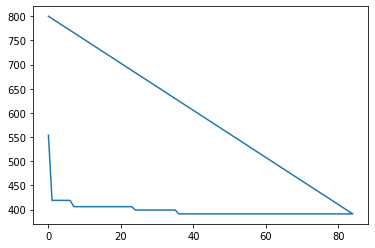

|  85       | -800.0    |  65.96    |  2.661    |  0.4783   |  0.007597 |  1.816e+0 |  3.126    |  0.2192   |  30.03    |  0.3876   |  0.6167   |  1.39     |  0.9787   |  2.822    |  6.761    |
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.15867
    momentum: 0.13
    nesterov: False
    weight_decay: 0.469
)
Batch Normalization Momentum:  0.74
Nodes:  6
LR:  0.15867
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.469
BATCH_SIZE:  79
Dropout:  0.15
Final Linear Layers:  1
average loss: 0.677520
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  21
Credit Cost:  -800


Best Score So Far:  -391


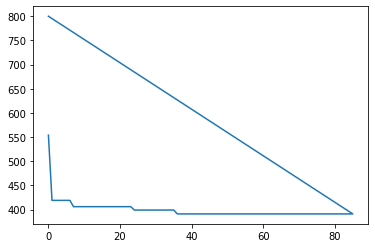

|  86       | -800.0    |  79.29    |  1.943    |  0.7403   |  0.1478   |  1.995e+0 |  1.118    |  0.1587   |  6.425    |  0.6382   |  0.469    |  2.067    |  0.1269   |  3.75     |  4.674    |
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.18989
    rho: 0.9
    weight_decay: 0.548
)
Batch Normalization Momentum:  0.77
Nodes:  15
LR:  0.18989
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.548
BATCH_SIZE:  24
Dropout:  0.2
Final Linear Layers:  3
average loss: 0.736645
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5952)
Class:  0  correct:  297.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4100)
Class:  1  correct:  41.0  of  tensor(100.)
Final percentage:  tensor(0.5026)
Last epoch:  41
Credit Cost:  -497


Best Score So Far:  -391


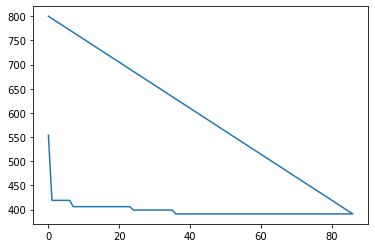

|  87       | -497.0    |  24.02    |  1.868    |  0.7663   |  0.1958   |  1.639e+0 |  3.057    |  0.1899   |  15.21    |  0.1463   |  0.5478   |  2.899    |  0.4164   |  1.228    |  5.238    |
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.30047
    momentum: 0.97
    nesterov: False
    weight_decay: 0.021
)
Batch Normalization Momentum:  0.03
Nodes:  13
LR:  0.30047
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.021
BATCH_SIZE:  82
Dropout:  0.07
Final Linear Layers:  2
average loss: 0.844204
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.6633)
Class:  0  correct:  331.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4300)
Class:  1  correct:  43.0  of  tensor(100.)
Final percentage:  tensor(0.5467)
Last epoch:  32
Credit Cost:  -453


Best Score So Far:  -391


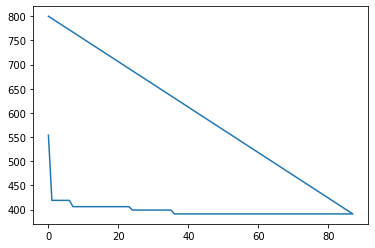

|  88       | -453.0    |  82.74    |  1.735    |  0.02601  |  0.07375  |  1.407e+0 |  2.013    |  0.3005   |  13.89    |  0.7897   |  0.02053  |  1.081    |  0.9653   |  2.469    |  4.76     |
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.20593
    rho: 0.9
    weight_decay: 0.489
)
Batch Normalization Momentum:  0.37
Nodes:  31
LR:  0.20593
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.489
BATCH_SIZE:  67
Dropout:  0.18
Final Linear Layers:  2
average loss: 0.689265
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5972)
Class:  0  correct:  298.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4900)
Class:  1  correct:  49.0  of  tensor(100.)
Final percentage:  tensor(0.5436)
Last epoch:  40
Credit Cost:  -456


Best Score So Far:  -391


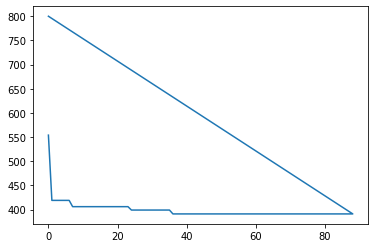

|  89       | -456.0    |  67.15    |  2.369    |  0.3719   |  0.1767   |  1.629e+0 |  2.578    |  0.2059   |  31.41    |  0.7288   |  0.4888   |  1.773    |  0.3238   |  2.719    |  5.979    |
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.37008
    weight_decay: 0.027
)
Batch Normalization Momentum:  0.66
Nodes:  22
LR:  0.37008
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.027
BATCH_SIZE:  95
Dropout:  0.0
Final Linear Layers:  3
average loss: 0.736540
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.2285)
Class:  0  correct:  114.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6500)
Class:  1  correct:  65.0  of  tensor(100.)
Final percentage:  tensor(0.4392)
Last epoch:  77
Credit Cost:  -560


Best Score So Far:  -391


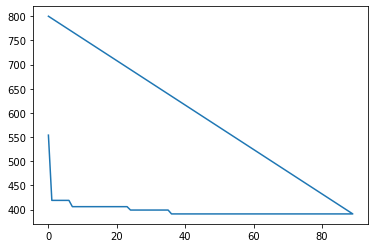

|  90       | -560.0    |  95.66    |  1.885    |  0.6579   |  0.00275  |  1.922e+0 |  3.185    |  0.3701   |  22.87    |  0.6374   |  0.02705  |  2.427    |  0.8516   |  2.531    |  3.335    |
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.01097
    rho: 0.9
    weight_decay: 0.61
)
Batch Normalization Momentum:  0.39
Nodes:  8
LR:  0.01097
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.61
BATCH_SIZE:  35
Dropout:  0.29
Final Linear Layers:  3
average loss: 0.694912
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.3006)
Class:  0  correct:  150.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.7800)
Class:  1  correct:  78.0  of  tensor(100.)
Final percentage:  tensor(0.5403)
Last epoch:  39
Credit Cost:  -459


Best Score So Far:  -391


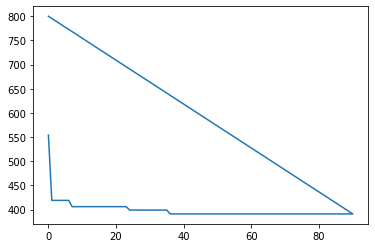

|  91       | -459.0    |  35.91    |  1.701    |  0.3929   |  0.2905   |  1.773e+0 |  3.076    |  0.01097  |  8.46     |  0.4309   |  0.6104   |  1.551    |  0.5737   |  1.877    |  5.702    |
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.02974
    momentum: 0.08
    nesterov: False
    weight_decay: 0.029
)
Batch Normalization Momentum:  0.79
Nodes:  19
LR:  0.02974
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.029
BATCH_SIZE:  127
Dropout:  0.17
Final Linear Layers:  1
average loss: 0.764129
Class:  0  accuracy:  tensor(0.5170)
Class:  0  correct:  258.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5700)
Class:  1  correct:  57.0  of  tensor(100.)
Final percentage:  tensor(0.5435)
Last epoch:  21
Credit Cost:  -456


Best Score So Far:  -391


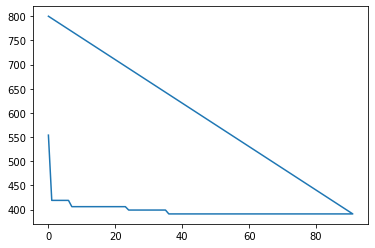

|  92       | -456.0    |  127.1    |  2.407    |  0.7853   |  0.1746   |  1.95e+03 |  1.161    |  0.02974  |  19.15    |  0.6381   |  0.0294   |  2.494    |  0.08116  |  1.122    |  4.799    |
Optimization:  Adagrad (
Parameter Group 0
    initial_accumulator_value: 0
    lr: 0.31817
    lr_decay: 0
    weight_decay: 0.237
)
Batch Normalization Momentum:  0.05
Nodes:  26
LR:  0.31817
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.237
BATCH_SIZE:  79
Dropout:  0.28
Final Linear Layers:  3
average loss: 0.693092
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  21
Credit Cost:  -800


Best Score So Far:  -391


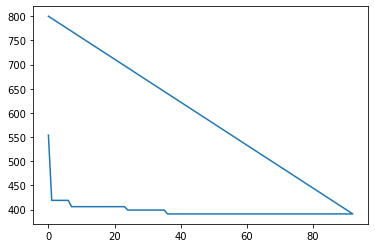

|  93       | -800.0    |  79.06    |  1.983    |  0.05127  |  0.2797   |  1.16e+03 |  3.866    |  0.3182   |  26.63    |  0.5462   |  0.237    |  2.845    |  0.06553  |  1.418    |  6.913    |
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.23392
    weight_decay: 0.228
)
Batch Normalization Momentum:  0.89
Nodes:  20
LR:  0.23392
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.228
BATCH_SIZE:  56
Dropout:  0.2
Final Linear Layers:  1
average loss: 0.690775
Class:  0  accuracy:  tensor(0.4028)
Class:  0  correct:  201.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.7000)
Class:  1  correct:  70.0  of  tensor(100.)
Final percentage:  tensor(0.5514)
Last epoch:  21
Credit Cost:  -448


Best Score So Far:  -391


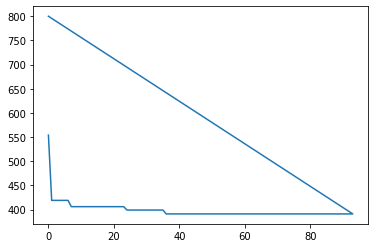

|  94       | -448.0    |  56.47    |  2.658    |  0.8935   |  0.2002   |  1.131e+0 |  1.952    |  0.2339   |  20.93    |  0.09632  |  0.2284   |  1.231    |  0.6949   |  1.291    |  1.529    |
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.31289
    weight_decay: 0.572
)
Batch Normalization Momentum:  0.23
Nodes:  22
LR:  0.31289
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.572
BATCH_SIZE:  8
Dropout:  0.22
Final Linear Layers:  3
average loss: 0.692751
Class:  0  accuracy:  tensor(0.5591)
Class:  0  correct:  279.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.6300)
Class:  1  correct:  63.0  of  tensor(100.)
Final percentage:  tensor(0.5946)
Last epoch:  21
Credit Cost:  -405


Best Score So Far:  -391


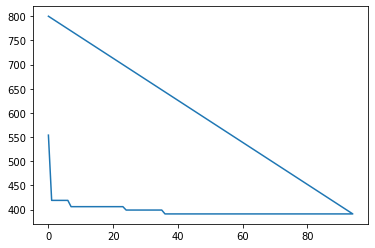

|  95       | -405.0    |  8.906    |  2.768    |  0.2273   |  0.2202   |  1.063e+0 |  3.549    |  0.3129   |  22.96    |  0.2963   |  0.5719   |  1.521    |  0.5205   |  3.535    |  1.463    |
Optimization:  Adagrad (
Parameter Group 0
    initial_accumulator_value: 0
    lr: 0.12401
    lr_decay: 0
    weight_decay: 0.672
)
Batch Normalization Momentum:  0.02
Nodes:  5
LR:  0.12401
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.672
BATCH_SIZE:  34
Dropout:  0.17
Final Linear Layers:  2
average loss: 0.693147
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  21
Credit Cost:  -800


Best Score So Far:  -391


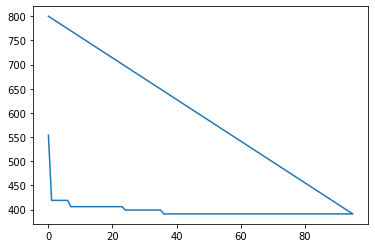

|  96       | -800.0    |  34.94    |  2.043    |  0.01882  |  0.1735   |  1.156e+0 |  2.341    |  0.124    |  5.902    |  0.9443   |  0.6725   |  1.415    |  0.3549   |  1.997    |  6.25     |
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.38063
    rho: 0.9
    weight_decay: 0.407
)
Batch Normalization Momentum:  0.85
Nodes:  8
LR:  0.38063
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.407
BATCH_SIZE:  74
Dropout:  0.14
Final Linear Layers:  2
average loss: 10.370014
average loss: 0.693147
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.3226)
Class:  0  correct:  161.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.5900)
Class:  1  correct:  59.0  of  tensor(100.)
Final percentage:  tensor(0.4563)
Last epoch:  112
Credit Cost:  -543


Best Score So Far:  -391


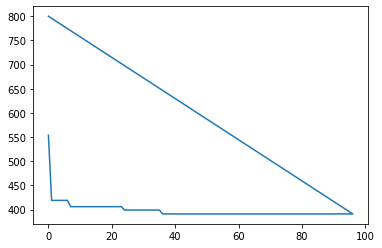

|  97       | -543.0    |  74.53    |  1.904    |  0.8505   |  0.1411   |  1.052e+0 |  2.822    |  0.3806   |  8.278    |  0.2724   |  0.4074   |  1.225    |  0.6485   |  3.76     |  5.277    |
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.12985
    weight_decay: 0.136
)
Batch Normalization Momentum:  0.38
Nodes:  14
LR:  0.12985
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.136
BATCH_SIZE:  84
Dropout:  0.12
Final Linear Layers:  1
average loss: 0.688723
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.6212)
Class:  0  correct:  310.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4500)
Class:  1  correct:  45.0  of  tensor(100.)
Final percentage:  tensor(0.5356)
Last epoch:  23
Credit Cost:  -464


Best Score So Far:  -391


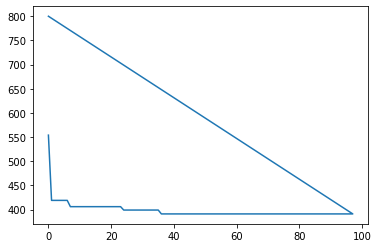

|  98       | -464.0    |  84.46    |  1.153    |  0.3805   |  0.1155   |  1.421e+0 |  1.875    |  0.1299   |  14.31    |  0.775    |  0.1362   |  1.925    |  0.4204   |  1.909    |  3.912    |
Optimization:  Adagrad (
Parameter Group 0
    initial_accumulator_value: 0
    lr: 0.10807
    lr_decay: 0
    weight_decay: 0.651
)
Batch Normalization Momentum:  0.56
Nodes:  11
LR:  0.10807
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.651
BATCH_SIZE:  42
Dropout:  0.09
Final Linear Layers:  2
average loss: 0.693147
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  499.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(100.)
Final percentage:  tensor(0.5000)
Last epoch:  21
Credit Cost:  -800


Best Score So Far:  -391


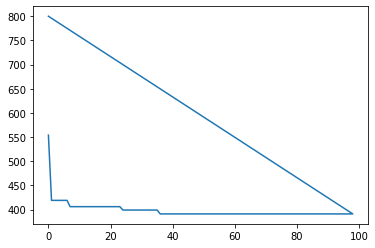

|  99       | -800.0    |  42.77    |  2.49     |  0.5583   |  0.09206  |  1.981e+0 |  2.625    |  0.1081   |  11.54    |  0.1768   |  0.6508   |  1.344    |  0.02651  |  1.587    |  6.048    |
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.22307
    weight_decay: 0.569
)
Batch Normalization Momentum:  0.44
Nodes:  13
LR:  0.22307
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.569
BATCH_SIZE:  127
Dropout:  0.2
Final Linear Layers:  1
average loss: 0.693425
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.6092)
Class:  0  correct:  304.0  of  tensor(499.)
Class:  1  accuracy:  tensor(0.4400)
Class:  1  correct:  44.0  of  tensor(100.)
Final percentage:  tensor(0.5246)
Last epoch:  29
Credit Cost:  -475


Best Score So Far:  -391


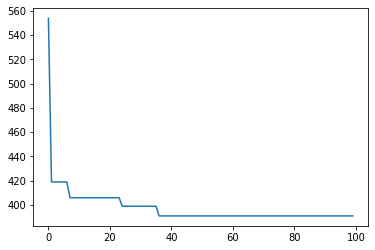

|  100      | -475.0    |  127.3    |  2.148    |  0.4353   |  0.1973   |  1.452e+0 |  1.566    |  0.2231   |  13.88    |  0.3579   |  0.5692   |  1.024    |  0.783    |  2.671    |  2.268    |
{'target': -391.0, 'params': {'SCI_BATCH_SIZE': 79.27967608458509, 'SCI_BIAS': 1.8230369658523111, 'SCI_BN_MOMENTUM': 0.8081879967089419, 'SCI_DROPOUT': 0.0555391194807092, 'SCI_EPOCHS': 1701.8765297563104, 'SCI_LINEARITY': 1.7186633182989253, 'SCI_LR': 0.2339454446479353, 'SCI_L_SECOND': 12.469627916623667, 'SCI_MM': 0.057850470683867054, 'SCI_REGULARIZATION': 0.16024668830516706, 'SCI_RELU': 2.321564085156039, 'SCI_SGD_MOMENTUM': 0.492277592426926, 'SCI_loss_type': 2.5518577923802996, 'SCI_optimizer': 2.0465736991524457}}
Iteration 0: 
	{'target': -554.0, 'params': {'SCI_BATCH_SIZE': 55.71072858311918, 'SCI_BIAS': 2.4334457419498947, 'SCI_BN_MOMENTUM': 0.00011323106917143777, 'SCI_DROPOUT': 0.09069977178955192, 'SCI_EPOCHS': 1146.7558908171131, 'SCI_LINEARITY': 1.2760923983587054, 'SCI_LR': 0.

In [4]:


if OPTIMIZATION_PLUGIN == 'Bayesian' :
    from bayes_opt import BayesianOptimization
    
    #def black_box_function(x, y):
    def objective(SCI_RELU, SCI_BIAS, SCI_loss_type, SCI_optimizer, SCI_BATCH_SIZE, SCI_MM, SCI_REGULARIZATION, SCI_LR, SCI_DROPOUT, SCI_L_SECOND, SCI_EPOCHS, SCI_BN_MOMENTUM, SCI_SGD_MOMENTUM, SCI_LINEARITY):
        global device, MaxCredit  
        global count, CreditVector, CreditVec

        
        SCI_BATCH_SIZE = int(SCI_BATCH_SIZE)                    # integer between 4 and 256
        SCI_MM = round(SCI_MM,3)                                # real with three decimals between (0.001, 0.999)
        SCI_REGULARIZATION = round(SCI_REGULARIZATION,3)        # real with three decimals between (0.001, 0.7)
        SCI_LR = round(SCI_LR,5)                                # real with five decimals between(1e-4, 7e-1)            
        SCI_DROPOUT = round(SCI_DROPOUT,2)                      # real with two decimals between (0, 0.4)
        SCI_L_SECOND = int(SCI_L_SECOND)                        # integer between 2 and 64
        SCI_EPOCHS = int(SCI_EPOCHS)                            # integer between (100, 500)
        SCI_BN_MOMENTUM = round(SCI_BN_MOMENTUM,2)              # real with two decimals between (0, 0.99)
        SCI_SGD_MOMENTUM = round(SCI_SGD_MOMENTUM,2)            # real with two decimals between (0, 0.99) 
        SCI_optimizer = int(SCI_optimizer)                      # integer between 1 and 4
        SCI_loss_type = int(SCI_loss_type)                      # integer between 1 and 3 ('CrossEntropyLoss', 'MultiMarginLoss','NLLLoss')
        SCI_LINEARITY = int(SCI_LINEARITY)
        if int(SCI_RELU) == 1 :                                 # integer between 1 and 2 ('True', 'False')
            SCI_RELU = True      
        else:
            SCI_RELU = False      
        if int(SCI_BIAS) == 1 :                                 # integer between 1 and 2 ('True', 'False')
            SCI_BIAS = True      
        else:
            SCI_BIAS = False  
               
        from cnn_model import CNN6
        cnn = CNN6(L_FIRST, SCI_L_SECOND, KERNEL_X, SCI_BIAS, SCI_BN_MOMENTUM, SCI_RELU, SCI_DROPOUT, dataset.CLASSES, SCI_LINEARITY)     
    
        if GPU_SELECT == 2:
            if torch.cuda.device_count() > 1:
                cnn = nn.DataParallel(cnn,device_ids=[0, 1], dim = 0) 
            cnn = cnn.cuda()                
        if GPU_SELECT == 1:
            cnn.to(device)  
        if GPU_SELECT == 0:
            cnn.to(device)        

        #next(cnn.parameters()).is_cuda
        #print(cnn)  # net architecture   
        #list(cnn.parameters()) 
        cnn.apply(CNN6.weights_reset)        
        cnn.share_memory()
     
        loss_func = nn.CrossEntropyLoss()

        def create_loss(LOSS):   
            if LOSS == 1:
                loss_func = nn.CrossEntropyLoss()
            if LOSS == 2:
                loss_func = nn.NLLLoss()
            else:
                loss_func = nn.MultiMarginLoss()
            return loss_func

        MM = float(str(SCI_MM))
        REGULARIZATION = float(str(SCI_REGULARIZATION))
        #optimizer = str(SCI_optimizer)
        LR = float(str(SCI_LR))
        train_losses = []         # to track the training loss as the model trains
        output = 0
        loss = 0
        accuracy = 0
        early_stopping.counter = 0
        early_stopping.best_score = None
        early_stopping.early_stop = False
        early_stopping.verbose = False  
        TEST_RESULTS = torch.zeros(1,2)
    
        loss_type = create_loss(SCI_loss_type)
    
        from adamw import AdamW
        
        
        if SCI_optimizer == 1:
            optimizer = optim.Adam(cnn.parameters(), lr=LR, betas=(0.9, 0.99), weight_decay=REGULARIZATION)
        if SCI_optimizer == 2:
            optimizer = optim.Adam(cnn.parameters(), lr=LR, betas=(0.9, 0.99), weight_decay=REGULARIZATION, amsgrad=True)
        if SCI_optimizer == 3:
            optimizer = AdamW(cnn.parameters(), lr=LR, betas=(0.9, 0.99), weight_decay = REGULARIZATION)           
        if SCI_optimizer == 4:
            optimizer = optim.SGD(cnn.parameters(), lr=LR, momentum=SCI_SGD_MOMENTUM, weight_decay=REGULARIZATION)
        if SCI_optimizer == 5:
            optimizer = optim.Adadelta(cnn.parameters(), lr=LR, weight_decay=REGULARIZATION)
        if SCI_optimizer == 6:
            optimizer = optim.Adagrad(cnn.parameters(), lr=LR, weight_decay=REGULARIZATION)
    
        from Utillities import Utillities
        Utillities.listing(optimizer, SCI_SGD_MOMENTUM, SCI_BN_MOMENTUM, SCI_L_SECOND, SCI_LR, SCI_RELU, SCI_BIAS, SCI_loss_type, REGULARIZATION, SCI_BATCH_SIZE, SCI_DROPOUT, SCI_LINEARITY)

    
        # Data Loader for easy mini-batch return in training
        SCI_BATCH_SIZE = int(SCI_BATCH_SIZE)
        train_loader = Data.DataLoader(dataset = dataset.train_dataset, batch_size = SCI_BATCH_SIZE, shuffle = True, num_workers = 0, drop_last=True, pin_memory=True)
        validation_loader = Data.DataLoader(dataset = dataset.validation_dataset, batch_size = 144, shuffle = True, num_workers = 0, drop_last=True, pin_memory=True)    
        test_loader = Data.DataLoader(dataset = dataset.test_dataset, batch_size = 599, shuffle = True, num_workers = 0, drop_last=True, pin_memory=True)
    
        for epoch in range(SCI_EPOCHS):
            loss = None        
            cnn.train().cuda()
            for step, (train_data, train_target) in enumerate(train_loader):   
                train_data, train_target = train_data.to(device), train_target.to(device)
                output, temp = cnn(train_data)                # forward pass: compute predicted outputs by passing inputs to the model     
                loss = loss_func(output, train_target)
                train_losses.append(loss.item())              # record training loss 
                loss.backward()                               # backward pass: compute gradient of the loss with respect to model parameters
                optimizer.zero_grad()
                optimizer.step()                              # perform a single optimization step (parameter update)
      
            cnn.eval().cuda()                 # switch to evaluation (no change) mode           
            valid_loss = 0
            accuracy = 0
            running_loss = 0.0
            with torch.no_grad():
                for step, (validation_data, validation_target) in enumerate(validation_loader):
                    validation_data, validation_target = validation_data.to(device), validation_target.to(device)
                    output, temp = cnn(validation_data)            # forward pass: compute predicted outputs by passing inputs to the model
                    valid_loss += loss_func(output, validation_target).item()
                    #ps = torch.exp(output)
                    #equality = (validation_target[0].data == ps.max(dim=1)[1])
                    #accuracy += equality.type(torch.FloatTensor).mean()    
                    #print('valid_loss: ', valid_loss)
                    
                    # print statistics
                running_loss += valid_loss
                if epoch % 100 == 0: 
                    print('average loss: %.6f' %(running_loss))
                    running_loss = 0.0
                   
            train_losses = []
            early_stopping(valid_loss, cnn)
        
            if early_stopping.early_stop:
                if os.path.exists('checkpoint.pt'):
                    #cnn = TheModelClass(*args, **kwargs)
                    print("Loaded the model with the lowest Validation Loss!")
                    cnn.load_state_dict(torch.load('checkpoint.pt'))  # Choose whatever GPU device number you want
                    cnn.to(device)
                break
      
        cnn.eval()
        class_correct = list(0. for i in range(1000))
        class_total = list(0. for i in range(1000))
        with torch.no_grad():
            for (test_data, test_target) in test_loader:
                test_data, test_target = test_data.to(device), test_target.to(device)
                outputs, temp = cnn(test_data)
                _, predicted = torch.max(outputs, 1)
                c = (predicted == test_target).squeeze()
                for i in range(test_target.size(0)):
                    label = test_target[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1

        for i in range(dataset.CLASSES):
            TEST_RESULTS[0,i] = class_correct[i] / dataset.TESTED_ELEMENTS[i]
            print('Class: ',i,' accuracy: ', TEST_RESULTS[0,i])   
            print('Class: ',i,' correct: ', class_correct[i],' of ',dataset.TESTED_ELEMENTS[i])
        percent = (TEST_RESULTS[0,0]+TEST_RESULTS[0,1])/2
        print('Final percentage: ',percent)
    
        CreditCost = int((1 - TEST_RESULTS[0,0]) * dataset.TESTED_ELEMENTS[0] + (1 - TEST_RESULTS[0,1]) * dataset.TESTED_ELEMENTS[1] * 5)
        
        if TEST_RESULTS[0,0] == 0 or TEST_RESULTS[0,1] == 0 :
            CreditCost = CreditCost + 300
    
        print('Last epoch: ', epoch)
        print('Credit Cost: ',-CreditCost)
        #list(cnn.parameters())
    
        if os.path.exists('checkpoint.pt'):  
            os.remove('checkpoint.pt') 

        print()
        
        
        print()
        
        if -CreditCost > MaxCredit : 
            MaxCredit = -CreditCost
        print('Best Score So Far: ',MaxCredit)    
        
        CreditVector[count] = MaxCredit    
        CreditVec[count] = count
        # plot the data
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(CreditVec, -CreditVector, color='tab:blue')
        #print(CreditVec, -CreditVector)
        count = count + 1
        # display the plot
        plt.show()
        
        return -CreditCost
    
    
    optimizer = BayesianOptimization(
        f=objective,
        #pbounds=pbounds,
        pbounds={'SCI_RELU': (1,2.99), 
                 'SCI_BIAS': (1,2.99), 
                 'SCI_loss_type': (1, 3.99), 
                 'SCI_optimizer': (1, 6.99),
                 'SCI_LR': (0.01, 0.4), 
                 'SCI_MM': (0.001, 0.999), 
                 'SCI_REGULARIZATION': (0.0001, 0.7), 
                 'SCI_EPOCHS': (1000, 2000), 
                 'SCI_BATCH_SIZE': (4, 128), 
                 'SCI_DROPOUT': (0, 0.3), 
                 'SCI_L_SECOND': (2, 32), 
                 'SCI_BN_MOMENTUM': (0, 0.99), 
                 'SCI_SGD_MOMENTUM': (0, 0.99), 
                 'SCI_LINEARITY': (1,3.99)},
        verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
        random_state=1,
    )
        

    #optimizer.maximize(
        #n_iter=TRIALS, acq="ucb", kappa=0.1
    #)
    
    
    optimizer.maximize(
        init_points = RANDOM_STARTS,
        n_iter = TRIALS,
        #acq="ucb", kappa=0.1
        
        acq="ei", xi=1e-4
    )
    
    
    print(optimizer.max)
    
    for i, res in enumerate(optimizer.res):
        print("Iteration {}: \n\t{}".format(i, res))

In [5]:
if OPTIMIZATION_PLUGIN == 'GradDescent' :
    import pandas as pd
    import matplotlib.pyplot as plt
    import torch
    import torch.optim as optim
    from torch.autograd import Variable
  

   
    #CI_LR = torch.randn(1).detach().requires_grad_(True)
    SCI_LR = 0.17
    SCI_REGULARIZATION = 0.03
    SCI_EPOCHS = 200
    #SCI_optimizer = 'Adam'
    SCI_loss_type = 'CrossEntropyLoss'
    SCI_RELU = 'True'
    SCI_BIAS = 'True'
    #SCI_L_SECOND = 48
    SCI_BN_MOMENTUM = 0.1

    SCI_SGD_MOMENTUM = torch.rand(1, requires_grad=True)
    print('SCI_SGD_MOMENTUM: ', SCI_SGD_MOMENTUM)
    SCI_BATCH_SIZE   = torch.randint(2, 128, (1,1), dtype=torch.float, requires_grad=True) 
    print('SCI_BATCH_SIZE: ',SCI_BATCH_SIZE)
    SCI_L_SECOND   = torch.randint(2, 96, (1,1), dtype=torch.float, requires_grad=True) 
    print('SCI_L_SECOND: ',SCI_L_SECOND)
    SCI_optimizer   = torch.randint(1, 6, (1,1), dtype=torch.float, requires_grad=True) 
    print('SCI_optimizer: ',SCI_optimizer)    
    SCI_DROPOUT      = torch.rand(1, requires_grad=True)    
    print('SCI_DROPOUT: ',SCI_DROPOUT)   
    

    def objective(SCI_SGD_MOMENTUM, SCI_DROPOUT, SCI_BATCH_SIZE, SCI_L_SECOND, SCI_optimizer, LINEARITY):
        global SCI_REGULARIZATION, SCI_EPOCHS, SCI_loss_type, SCI_RELU
        global SCI_BIAS, SCI_BN_MOMENTUM, device, SCI_LR, MaxCredit, count, CreditVector, CreditVec
        
        SCI_SGD_MOMENTUM = SCI_SGD_MOMENTUM/10
        DROPOUT = (SCI_DROPOUT/2).item()
        if SCI_DROPOUT < 0 :
            DROPOUT = 0

        BATCH_SIZE = int(SCI_BATCH_SIZE)
        
        if SCI_L_SECOND < 4 :
            SCI_L_SECOND = 4
            
        if SCI_optimizer < 1 :
            SCI_optimizer = 1
        
        L_SECOND = int(SCI_L_SECOND)
        
        loss_func = nn.CrossEntropyLoss()

        def create_loss(LOSS):   
            if LOSS == 'CrossEntropyLoss':
                loss_func = nn.CrossEntropyLoss()
            if LOSS == 'NLLLoss':
                loss_func = nn.NLLLoss()
            else:
                loss_func = nn.MultiMarginLoss()
            return loss_func


        REGULARIZATION = float(str(SCI_REGULARIZATION))
        optimizer1 = str(SCI_optimizer)

        from cnn_model import CNN6      
        cnn = CNN6(L_FIRST, L_SECOND, KERNEL_X, SCI_BIAS, SCI_BN_MOMENTUM, SCI_RELU, DROPOUT, dataset.CLASSES, LINEARITY)     
    
        if GPU_SELECT == 2:
            if torch.cuda.device_count() > 1:
                cnn = nn.DataParallel(cnn,device_ids=[0, 1], dim=0) 
            cnn = cnn.cuda()
        if GPU_SELECT == 1:
            cnn.to(device)  
        if GPU_SELECT == 0:
            cnn.to(device)        

        cnn.apply(CNN6.weights_reset)
        cnn.share_memory()


        train_losses = []         # to track the training loss as the model trains
        output = 0
        loss = 0
        accuracy = 0
        early_stopping.counter = 0
        early_stopping.best_score = None
        early_stopping.early_stop = False
        early_stopping.verbose = False  
        TEST_RESULTS = torch.zeros(1,2)

    
        loss_type = create_loss(SCI_loss_type)
        
        from adamw import AdamW
        
        
        if optimizer1 == '1':
            optimizer = optim.Adam(cnn.parameters(), lr=SCI_LR, betas=(0.9, 0.99), weight_decay=REGULARIZATION)
        if optimizer1 == '2':
            optimizer = optim.Adam(cnn.parameters(), lr=SCI_LR, betas=(0.9, 0.99), weight_decay=REGULARIZATION, amsgrad=True)
        if optimizer1 == '3':
            optimizer = AdamW(cnn.parameters(), lr=SCI_LR, betas=(0.9, 0.99), weight_decay = REGULARIZATION)            
        if optimizer1 == '4':
            optimizer = optim.SGD(cnn.parameters(), lr=SCI_LR, momentum=SCI_SGD_MOMENTUM, weight_decay=REGULARIZATION)
        if optimizer1 == '5':
            optimizer = optim.Adadelta(cnn.parameters(), lr=SCI_LR, weight_decay=REGULARIZATION)
        if optimizer1 == '6':
            optimizer = optim.Adagrad(cnn.parameters(), lr=SCI_LR, weight_decay=REGULARIZATION)
        if optimizer1  > '6':           
            optimizer = optim.Adam(cnn.parameters(), lr=SCI_LR, betas=(0.9, 0.99), weight_decay=REGULARIZATION)

    
        from Utillities import Utillities
        Utillities.listing(optimizer, SCI_SGD_MOMENTUM, SCI_BN_MOMENTUM, L_SECOND, SCI_LR, SCI_RELU, SCI_BIAS, SCI_loss_type, REGULARIZATION, BATCH_SIZE, DROPOUT, LINEARITY)

        train_loader = Data.DataLoader(dataset = dataset.train_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = 0, drop_last=True, pin_memory=True)
        validation_loader = Data.DataLoader(dataset = dataset.validation_dataset, batch_size = 144, shuffle = False, num_workers = 0, drop_last=True, pin_memory=True)    
        test_loader = Data.DataLoader(dataset = dataset.test_dataset, batch_size = 599, shuffle = False, num_workers = 0, pin_memory=True, drop_last=True)
    
        for epoch in range(SCI_EPOCHS):
            loss = None        
            cnn.train().cuda()
            for step, (train_data, train_target) in enumerate(train_loader):   
                train_data, train_target = train_data.to(device), train_target.to(device)
                output, temp = cnn(train_data)                # forward pass: compute predicted outputs by passing inputs to the model     
                loss = loss_func(output, train_target)
                train_losses.append(loss.item())              # record training loss 
                loss.backward()                               # backward pass: compute gradient of the loss with respect to model parameters
                optimizer.zero_grad()
                optimizer.step()                              # perform a single optimization step (parameter update)
      
            cnn.eval().cuda()                 # switch to evaluation (no change) mode           
            valid_loss = 0
            accuracy = 0
            with torch.no_grad():
                for step, (validation_data, validation_target) in enumerate(validation_loader):
                    validation_data, validation_target = validation_data.to(device), validation_target.to(device)
                    output, temp = cnn(validation_data)            # forward pass: compute predicted outputs by passing inputs to the model
                    valid_loss += loss_func(output, validation_target).item()
                    ps = torch.exp(output)
                    equality = (validation_target[0].data == ps.max(dim=1)[1])
                    accuracy += equality.type(torch.FloatTensor).mean()      
               
            train_losses = []
            early_stopping(valid_loss, cnn)
       
            if early_stopping.early_stop:
                if os.path.exists('checkpoint.pt'):
                    print("Loaded the model with the lowest Validation Loss!")
                    cnn.load_state_dict(torch.load('checkpoint.pt', map_location="cuda:1"))  # Choose whatever GPU device number you want
                    cnn.to(device)
                break
      
        cnn.eval()
        class_correct = list(0. for i in range(1000))
        class_total = list(0. for i in range(1000))
        with torch.no_grad():
            for (test_data, test_target) in test_loader:
                test_data, test_target = test_data.to(device), test_target.to(device)
                outputs, temp = cnn(test_data)
                _, predicted = torch.max(outputs, 1)
                c = (predicted == test_target).squeeze()
                for i in range(test_target.size(0)):
                    label = test_target[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1

        for i in range(dataset.CLASSES):
            TEST_RESULTS[0,i] = class_correct[i] / dataset.TESTED_ELEMENTS[i]
            print('Class: ',i,' accuracy: ', TEST_RESULTS[0,i])
            print('Class: ',i,' correct: ', class_correct[i])
        percent = (TEST_RESULTS[0,0]+TEST_RESULTS[0,1])/2
        print('Final percentage: ',percent)
    
        CreditCost = (1 - TEST_RESULTS[0,0]) * dataset.TESTED_ELEMENTS[0] + (1 - TEST_RESULTS[0,1]) * dataset.TESTED_ELEMENTS[1] * 5
    
        if TEST_RESULTS[0,0] == 0 or TEST_RESULTS[0,1] == 0 :
            CreditCost = CreditCost + 300
    
        print('Last epoch: ', epoch)
   
        if os.path.exists('checkpoint.pt'):  
            os.remove('checkpoint.pt') 

        print()
        torch.cuda.empty_cache()
        print()
        
        CreditCost = CreditCost + (SCI_SGD_MOMENTUM + SCI_DROPOUT + SCI_BATCH_SIZE + SCI_L_SECOND + SCI_optimizer)/1000
        print('Credit Cost: ',CreditCost)
        
        
        if -CreditCost > MaxCredit : 
            MaxCredit = -CreditCost
        print('Best Score So Far: ',MaxCredit)   
        
        CreditVector[count] = MaxCredit    
        CreditVec[count] = count
        # plot the data
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(CreditVec, -CreditVector, color='tab:orange')
        #print(CreditVec, -CreditVector)
        count = count + 1
        # display the plot
        plt.show()
             
        return CreditCost

    
    def loss(y_predicted, expected):
        return (y_predicted - expected).sum()
            
    
    expected = 300
    
    #optim_alg = optim.Adagrad([SCI_SGD_MOMENTUM, SCI_DROPOUT, SCI_BATCH_SIZE, SCI_L_SECOND], lr=0.01)
    optim_alg = optim.Adam([       
        {'params': SCI_SGD_MOMENTUM, 'lr': 1e-3},
        {'params': SCI_DROPOUT, 'lr': 1e-2},
        {'params': SCI_BATCH_SIZE, 'lr': 0.5},
        {'params': SCI_L_SECOND, 'lr': 0.5},
        {'params': SCI_optimizer, 'lr': 0.25}
        ]) 
    
    LINEARITY = 2
    # Main optimization loop
    for t in range(RANDOM_STARTS + TRIALS):
        optim_alg.zero_grad()
        y_predicted = objective(SCI_SGD_MOMENTUM, SCI_DROPOUT, SCI_BATCH_SIZE, SCI_L_SECOND, SCI_optimizer, LINEARITY)
        current_loss = loss(y_predicted, expected)
        current_loss.backward()
        optim_alg.step()
        print(f"t = {t}, loss = {current_loss}, SCI_DROPOUT = {SCI_DROPOUT.detach().numpy()}, SCI_SGD_MOMENTUM = {SCI_SGD_MOMENTUM.item()}, SCI_BATCH_SIZE = {SCI_BATCH_SIZE.detach().numpy()}, SCI_L_SECOND = {SCI_L_SECOND.detach().numpy()}, SCI_optimizer = {SCI_optimizer.detach().numpy()}")
    

In [6]:
end.record()

#print('Minimum Credit Cost: ',Min_Credit_Cost)

print()
print('Total execution time (minutes): ',start.elapsed_time(end)/60000)

torch.cuda.empty_cache()

if GET_STATS:
    pr.disable()
    s = io.StringIO()
    sortby = SortKey.CUMULATIVE
    ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
    ps.print_stats()
    print(s.getvalue())


Total execution time (minutes):  3.2802880208333334
